## IMSE 586 Project
### Classify and Predict Injury Severity Using Crash Reporting Sampling System (CRSS) Data of the Most Recent Years

#### **team 16**: Meghanath Payasam, Golnoosh Garakani and Ayegba David Haruna.

In [179]:
# import needed modules 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install dython
from dython.nominal import associations
from matplotlib.lines import Line2D
from imblearn.over_sampling import SMOTEN

In [180]:
# columes used from the accident.csv

columns_to_extract = [
    "CASENUM", "REGION", "REGIONNAME",
    "NUM_INJ", "MONTH", "MONTHNAME", "YEAR", "DAY_WEEKNAME", "ALCOHOLNAME", "MAX_SEV", 
    "MAX_SEVNAME", "WEATHERNAME"
]

len(columns_to_extract)

12

### Data loading

In [181]:
accident_2019 = pd.read_csv("./CRSS2019CSV/accident.csv",usecols=columns_to_extract)
accident_2020 = pd.read_csv("./CRSS2020CSV/accident.csv",usecols=columns_to_extract)
accident_2021 = pd.read_csv("./CRSS2021CSV/accident.csv",usecols=columns_to_extract)

In [182]:
person_2019 = pd.read_csv("./CRSS2019CSV/person.csv",
                          encoding='latin-1',
                         usecols=["CASENUM","AGE","REST_MIS","PER_TYP"])
person_2019['YEAR']=2019
person_2020 = pd.read_csv("./CRSS2020CSV/person.csv",
                          encoding='latin-1',
                         usecols=["CASENUM","AGE","REST_MIS","PER_TYP"])
person_2020['YEAR']=2020
person_2021 = pd.read_csv("./CRSS2021CSV/person.csv",
                          encoding='latin-1',
                         usecols=["CASENUM","AGE","REST_MIS","PER_TYP"])
person_2021['YEAR']=2021


In [183]:
vehicle_2019 = pd.read_csv("./CRSS2019CSV/vehicle.csv",
                          encoding='latin-1',
                         usecols=["CASENUM","SPEEDREL"])
vehicle_2019['YEAR']=2019

vehicle_2020 = pd.read_csv("./CRSS2020CSV/vehicle.csv",
                          encoding='latin-1',
                         usecols=["CASENUM","SPEEDREL"])
vehicle_2020['YEAR']=2020

vehicle_2021 = pd.read_csv("./CRSS2021CSV/vehicle.csv",
                          encoding='latin-1',
                         usecols=["CASENUM","SPEEDREL"])
vehicle_2021['YEAR']=2021

In [184]:
distract_2019= pd.read_csv("./CRSS2019CSV/distract.csv",
                          encoding='latin-1',
                         usecols=["CASENUM","MDRDSTRDNAME"])
distract_2019['YEAR']=2019
distract_2019.rename(columns={"MDRDSTRDNAME":"DRDISTRACTNAME"},inplace=True)
distract_2020= pd.read_csv("./CRSS2020CSV/distract.csv",
                          encoding='latin-1',
                         usecols=["CASENUM","DRDISTRACTNAME"])
distract_2020['YEAR']=2020

distract_2021= pd.read_csv("./CRSS2021CSV/distract.csv",
                          encoding='latin-1',
                         usecols=["CASENUM","DRDISTRACTNAME"])
distract_2021['YEAR']=2021

In [185]:
accident_2019_2021 = pd.concat([accident_2019,accident_2020,accident_2021], axis=0, ignore_index=True)
# print(accident_2019_2021.columns)
accident_2019_2021.shape

(163354, 12)

In [186]:
person_2019_2021 = pd.concat([person_2019,person_2020,person_2021], axis=0, ignore_index=True)
# print(person_2019_2021.columns)
person_2019_2021.shape

(401106, 5)

In [187]:
vehicle_2019_2021 = pd.concat([vehicle_2019,vehicle_2020,vehicle_2021],axis=0,ignore_index=True)
vehicle_2019_2021.head()

,CASENUM,SPEEDREL,YEAR
0,201901174219,4,2019
1,201901176655,0,2019
2,201901176655,0,2019
3,201901176667,0,2019
4,201901176667,0,2019


In [132]:
distract_2019_2021 = pd.concat([distract_2019,distract_2020,distract_2021], axis=0, ignore_index=True)
distract_2019_2021.head()

,CASENUM,DRDISTRACTNAME,YEAR
0,201901174219,Not Distracted,2019
1,201901176655,Not Reported,2019
2,201901176655,Not Reported,2019
3,201901176667,"Inattention (Inattentive), Details Unknown",2019
4,201901176667,Not Reported,2019


In [133]:
#adding year to the dataframes and setting it to datetime.

accident_2019_2021['YEAR'] = pd.to_datetime(accident_2019_2021['YEAR'], format='%Y')
person_2019_2021['YEAR'] = pd.to_datetime(person_2019_2021['YEAR'], format='%Y')
vehicle_2019_2021['YEAR'] = pd.to_datetime(vehicle_2019_2021['YEAR'], format='%Y')
distract_2019_2021['YEAR'] = pd.to_datetime(distract_2019_2021['YEAR'], format='%Y')

In [134]:
accident_2019_2021['YEAR'] = accident_2019_2021['YEAR'].dt.year
person_2019_2021['YEAR'] = person_2019_2021['YEAR'].dt.year
vehicle_2019_2021['YEAR'] = vehicle_2019_2021['YEAR'].dt.year
distract_2019_2021['YEAR'] = distract_2019_2021['YEAR'].dt.year

In [135]:
accident_2019_2021.set_index(["CASENUM","YEAR"],inplace=True)
person_2019_2021.set_index(["CASENUM","YEAR"],inplace=True)
vehicle_2019_2021.set_index(["CASENUM","YEAR"],inplace=True)
distract_2019_2021.set_index(["CASENUM","YEAR"],inplace=True)

In [136]:
analysis_data = accident_2019_2021.join(person_2019_2021, on=["CASENUM", "YEAR"], how='inner')

# joining all datafeames.
analysis_data = analysis_data.join(vehicle_2019_2021, on=["CASENUM", "YEAR"], how='inner')
analysis_data = analysis_data.join(distract_2019_2021, on=["CASENUM", "YEAR"], how='inner')

# Sorting
analysis_data.sort_values(['CASENUM', 'YEAR'], inplace=True)

print(analysis_data.shape)


(1775874, 15)


### Data cleaning and processing

In [137]:
# renaming values for better readability.


analysis_data['REGIONNAME'].replace({'South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)':'South',
                             'West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI)':'West',
       'Midwest (OH, IN, IL, MI, WI, MN, ND, SD, NE, IA, MO, KS)':'Midwest',
       'Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT)':'Northeast'}
                             ,inplace=True)

In [138]:
analysis_data['MAX_SEVNAME'].value_counts()

No Apparent Injury (O)          740970
Possible Injury (C)             469961
Suspected Minor Injury (B)      299911
Suspected Serious Injury (A)    207457
Fatal Injury (K)                 46719
Unknown/Not Reported              6477
Injured, Severity Unknown         4372
Died Prior to Crash*                 7
Name: MAX_SEVNAME, dtype: int64

In [139]:
# analysis_data = analysis_data[~analysis_data['MAX_SEVNAME'].isin(['No Apparent Injury (O)', 'Unknown/Not Reported'])]

In [140]:
## adding new column for fatality
analysis_data['SEVERE_INJURY']=analysis_data['MAX_SEVNAME'].apply(lambda x: 'Fatal/Severe' 
                                                             if ((x == 'Fatal Injury (K)') | (x == 'Suspected Serious Injury (A)')) 
                                                             else 'Minor/No_injury'
                                                            )

In [141]:
## adding new col for age group
analysis_data['AGE_GROUP']= analysis_data['AGE'].apply(lambda x: 'Teens' if ((x>=14) & (x<=19))
                                                       else ( 
                                                           'YoungAdult' if ((x>=20) & (x<=25)) 
                                                           else ( 
                                                               'Adult' if ((x>=26) & (x<=65))
                                                                           else ( 'SeniorCitizen' if ((x>65)&(x<=120))
                                                                                 else ('Not Reported')
                                                                                ) )))
                                                       

In [142]:
# extracting only driver's records from the df (PER_TYP==1)

analysis_data = analysis_data[analysis_data['PER_TYP']==1]
analysis_data= analysis_data[analysis_data['REST_MIS'] != 8]
analysis_data.shape

(1288274, 17)

#### merging similar values for better analysis

In [143]:


analysis_data['DIST_NAME']= analysis_data['DRDISTRACTNAME'].apply(lambda x: "No Distraction" if (x== 'Not Distracted')
                                                                 else(
                                                                 'Not Reported' if (x=='Not Reported' or x== 'No Driver Present/Unknown if Driver present')
                                                                     else (
                                                                     'Mobile/Car Integrals' if (x=='While Manipulating Mobile Phone'
                                                                                               or x=='Other Mobile Phone Related'
                                                                                               or x== 'While Using Other Component/Controls Integral to Vehicle'
                                                                                               or x== 'Adjusting Audio Or Climate Controls'
                                                                                               or x== 'While Talking or Listening to Mobile Phone')
                                                                         
                                                                             else(
                                                                             'Food/By Occupants' if (x=='Eating or Drinking'
                                                                                                      or x=='Smoking Related'
                                                                                                      or x== 'By Other Occupant(s)')
                                                                                 else 'By Outside/Others'
                                                                             
                                                                                                           
                                                                         )
                                                                     )
                                                                 ) )

In [144]:
## only for piechart viz. For better visuals

analysis_data['DIST_NAME_']= analysis_data['DRDISTRACTNAME'].apply(lambda x: "No Distraction" if (x== 'Not Distracted')
                                                                 else(
                                                                 'Not Reported' if (x=='Not Reported' or x== 'No Driver Present/Unknown if Driver present')
                                                                     else (
                                                                     'Mobile/Food/Occupents' if (x=='While Manipulating Mobile Phone'
                                                                                               or x=='Other Mobile Phone Related'
                                                                                               or x== 'While Using Other Component/Controls Integral to Vehicle'
                                                                                               or x== 'Adjusting Audio Or Climate Controls'
                                                                                               or x== 'While Talking or Listening to Mobile Phone'
                                                                                               or x=='Eating or Drinking'
                                                                                                or x=='Smoking Related'
                                                                                                or x== 'By Other Occupant(s)')
                                                                         
                                                                             
                                                                                 else 'By Outside/Others'
                                                                     )
                                                                 ) )

In [145]:
analysis_data['SPEEDREL']=analysis_data['SPEEDREL'].apply(lambda x: 'No Speeding' if (x==0)
                                                         else(
                                                         'Speeding' if (x in [2,3,4,5])
                                                             else(
                                                             'Unknown'
                                                             )
                                                         )
                                                         )

In [146]:

analysis_data['REST_MIS']= analysis_data['REST_MIS'].apply(lambda x: 'No Misuse' if (x == 0)
                                                           else(
                                                               'Misued/Not_Used'
                                                           )
)

In [147]:
analysis_data['WEATHER_CND']=analysis_data['WEATHERNAME'].apply(lambda x: 'Not Reported/Unknown' if (x== 'Not Reported' or x== 'Reported as Unknown')
                                                                else ( 
                                                                    'Cloudy/Fog/Winds/Others' if (x== 'Fog, Smog, Smoke' or x== 'Blowing Sand, Soil, Dirt' or x == 'Other' or x=='Cloudy' or x=='Severe Crosswinds')
                                                                    else(
                                                                    'Snow' if (x=='Snow' or x== 'Blowing Snow' )
                                                                        else(
                                                                        'Rain' if (x== 'Rain' or x=='Sleet or Hail' or x=='Freezing Rain or Drizzle')
                                                                            else(
                                                                            x)
                                                                        )
                                                                    )
                                                                
                                                                )
)

In [148]:
analysis_data['ALCOHOL_INV']=analysis_data['ALCOHOLNAME'].apply(lambda x: 'Unknown/Not applicable' if (x == 'No Alcohol Involved')
                                                                else (
                                                                    x
                                                                )
    
    
    
)

In [149]:
analysis_data['MAX_SEVNAME'].value_counts()

No Apparent Injury (O)          572648
Possible Injury (C)             329662
Suspected Minor Injury (B)      206212
Suspected Serious Injury (A)    140502
Fatal Injury (K)                 30518
Unknown/Not Reported              5547
Injured, Severity Unknown         3178
Died Prior to Crash*                 7
Name: MAX_SEVNAME, dtype: int64

In [150]:
analysis_data=analysis_data.reset_index()
# analysis_data.set_index(['CASENUM'],inplace=True)

In [151]:
analysis_data.head()

,CASENUM,YEAR,REGION,REGIONNAME,NUM_INJ,MONTH,MONTHNAME,DAY_WEEKNAME,ALCOHOLNAME,MAX_SEV,...,PER_TYP,REST_MIS,SPEEDREL,DRDISTRACTNAME,SEVERE_INJURY,AGE_GROUP,DIST_NAME,DIST_NAME_,WEATHER_CND,ALCOHOL_INV
0,201901174219,2019,3,South,0,1,January,Tuesday,No Alcohol Involved,0,...,1,No Misuse,Speeding,Not Distracted,Minor/No_injury,Adult,No Distraction,No Distraction,Cloudy/Fog/Winds/Others,Unknown/Not applicable
1,201901176655,2019,3,South,2,1,January,Tuesday,Reported as Unknown,1,...,1,No Misuse,No Speeding,Not Reported,Minor/No_injury,YoungAdult,Not Reported,Not Reported,Clear,Reported as Unknown
2,201901176655,2019,3,South,2,1,January,Tuesday,Reported as Unknown,1,...,1,No Misuse,No Speeding,Not Reported,Minor/No_injury,YoungAdult,Not Reported,Not Reported,Clear,Reported as Unknown
3,201901176655,2019,3,South,2,1,January,Tuesday,Reported as Unknown,1,...,1,No Misuse,No Speeding,Not Reported,Minor/No_injury,YoungAdult,Not Reported,Not Reported,Clear,Reported as Unknown
4,201901176655,2019,3,South,2,1,January,Tuesday,Reported as Unknown,1,...,1,No Misuse,No Speeding,Not Reported,Minor/No_injury,YoungAdult,Not Reported,Not Reported,Clear,Reported as Unknown


### EDA/ Viz

In [152]:
analysis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288274 entries, 0 to 1288273
Data columns (total 23 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   CASENUM         1288274 non-null  int64 
 1   YEAR            1288274 non-null  int64 
 2   REGION          1288274 non-null  int64 
 3   REGIONNAME      1288274 non-null  object
 4   NUM_INJ         1288274 non-null  int64 
 5   MONTH           1288274 non-null  int64 
 6   MONTHNAME       1288274 non-null  object
 7   DAY_WEEKNAME    1288274 non-null  object
 8   ALCOHOLNAME     1288274 non-null  object
 9   MAX_SEV         1288274 non-null  int64 
 10  MAX_SEVNAME     1288274 non-null  object
 11  WEATHERNAME     1288274 non-null  object
 12  AGE             1288274 non-null  int64 
 13  PER_TYP         1288274 non-null  int64 
 14  REST_MIS        1288274 non-null  object
 15  SPEEDREL        1288274 non-null  object
 16  DRDISTRACTNAME  1288274 non-null  object
 17  SEVERE_I

In [153]:
injuries_over_years = analysis_data.groupby(by=['YEAR','SEVERE_INJURY'])['CASENUM'].count()

injuries_over_years

YEAR  SEVERE_INJURY  
2019  Fatal/Severe        56034
      Minor/No_injury    384654
2020  Fatal/Severe        62412
      Minor/No_injury    354052
2021  Fatal/Severe        52574
      Minor/No_injury    378548
Name: CASENUM, dtype: int64

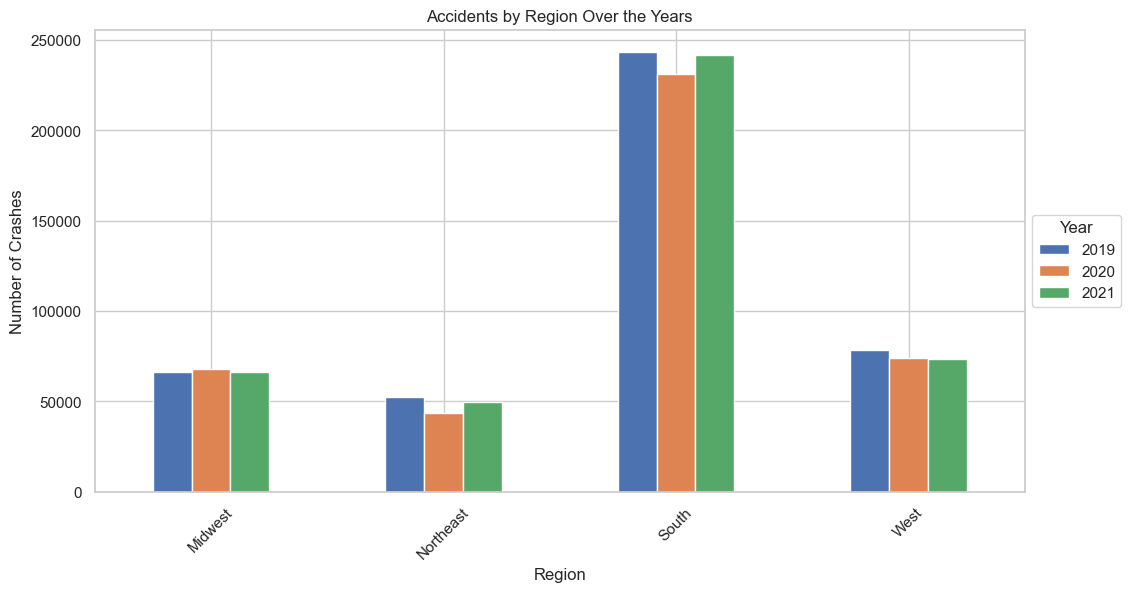

In [154]:
grouped = analysis_data.groupby(['REGIONNAME', 'YEAR'])['CASENUM'].count().unstack()
categories = ['Midwest', 'Northeast', 'South', 'West']

grouped.plot(kind='bar', figsize=(12, 6))
plt.title('Accidents by Region Over the Years')
plt.xlabel('Region')
plt.ylabel('Number of Crashes')
plt.legend(title='Year', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(range(len(categories)), categories,rotation=45)
plt.show()

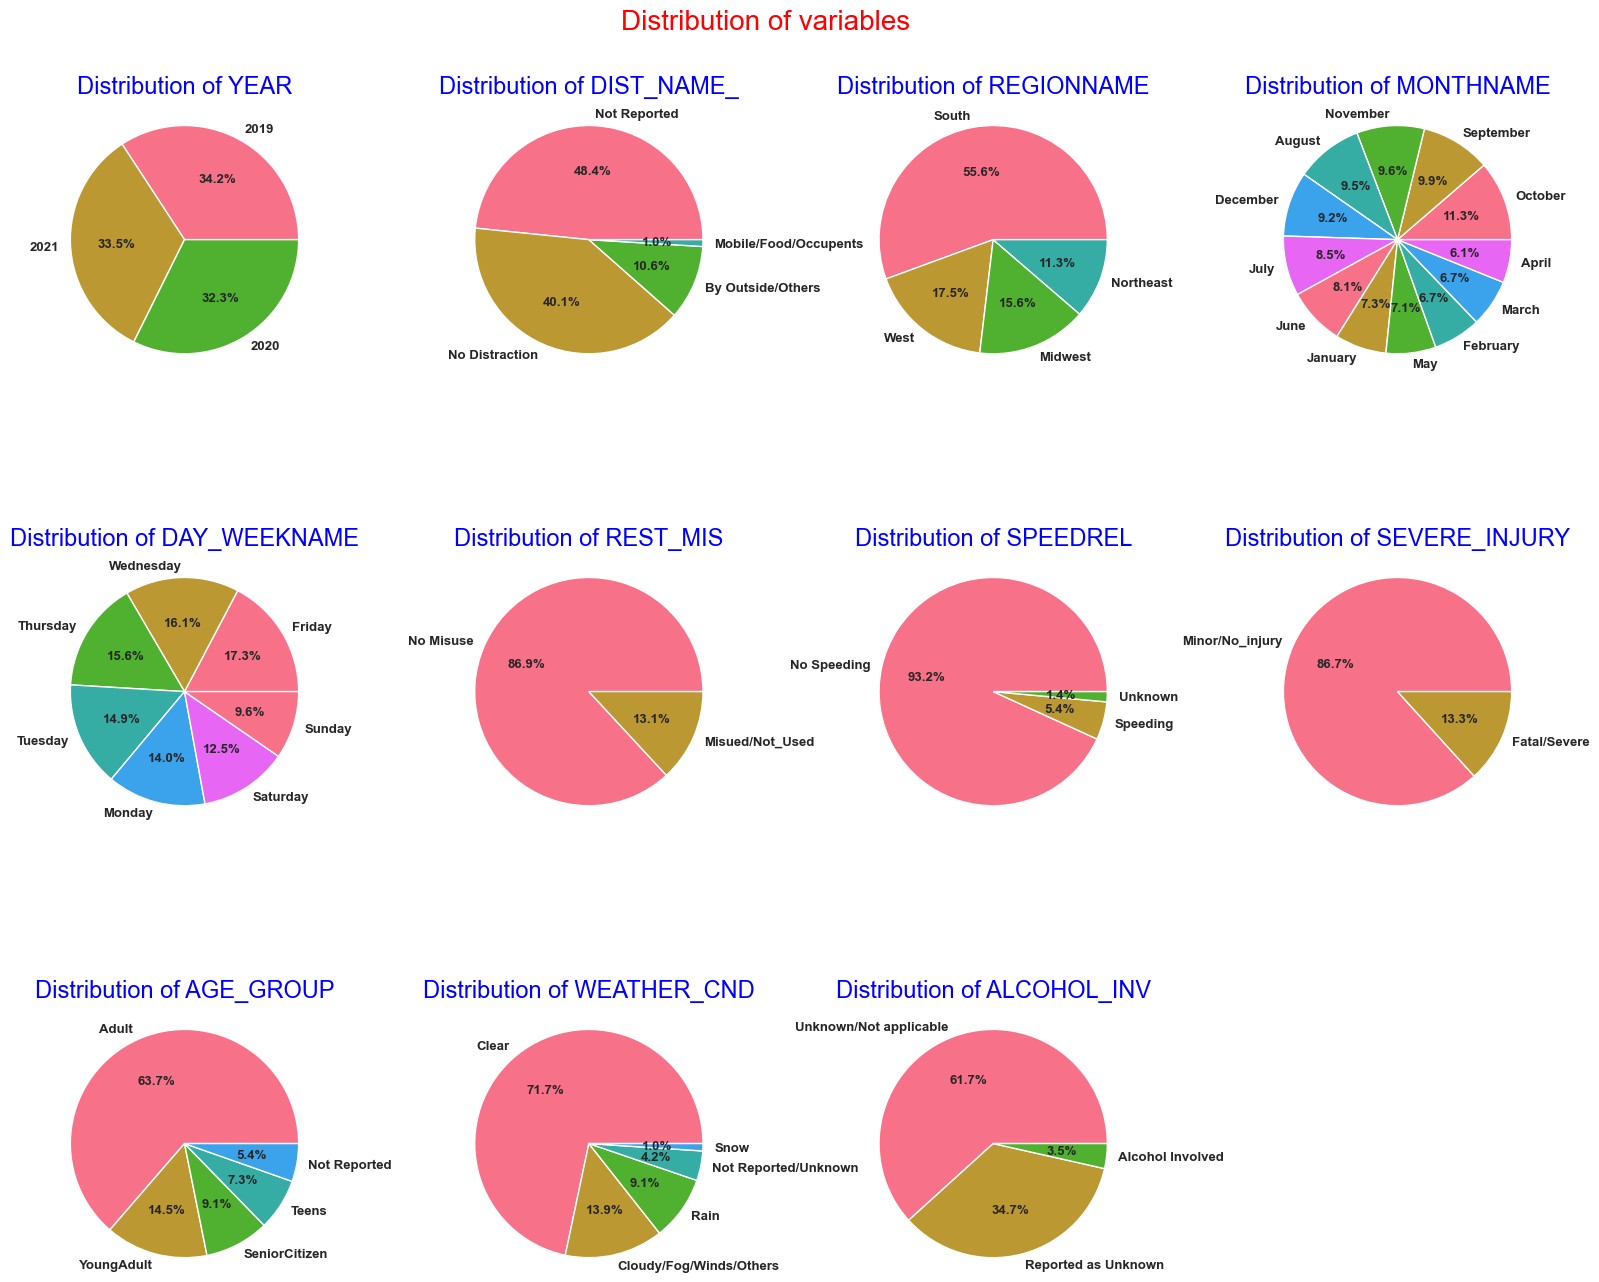

In [155]:
variables_to_visualize=['YEAR', 'DIST_NAME_', 'REGIONNAME', 'MONTHNAME',
                           'DAY_WEEKNAME', 'REST_MIS', 'SPEEDREL',
                           'SEVERE_INJURY', 'AGE_GROUP',
                           'WEATHER_CND', 'ALCOHOL_INV','Empty']


fig,axes=plt.subplots(nrows=3, ncols=4,figsize=(20, 15))
fig.subplots_adjust(hspace=0.8)
fig.suptitle('Distribution of variables',y=.95,fontsize=20,color = 'red')

axes = axes.flatten()

# looping throgh the variables and create a pie chart for each
for i,(variable,ax) in enumerate(zip(variables_to_visualize, axes)):
    if(i==11):
        ax.set_axis_off()
        break
    
    data_counts=analysis_data[variable].value_counts()
    ax.pie(data_counts, labels=data_counts.index, autopct='%1.1f%%', colors=sns.color_palette('husl'), textprops={'fontsize': 9.5, 'weight':'bold'})
    ax.set_title(f'Distribution of {variable}',y=1.05,fontsize=17, color = 'blue')
    ax.axis('equal')
    
plt.show()


<Figure size 1200x600 with 0 Axes>

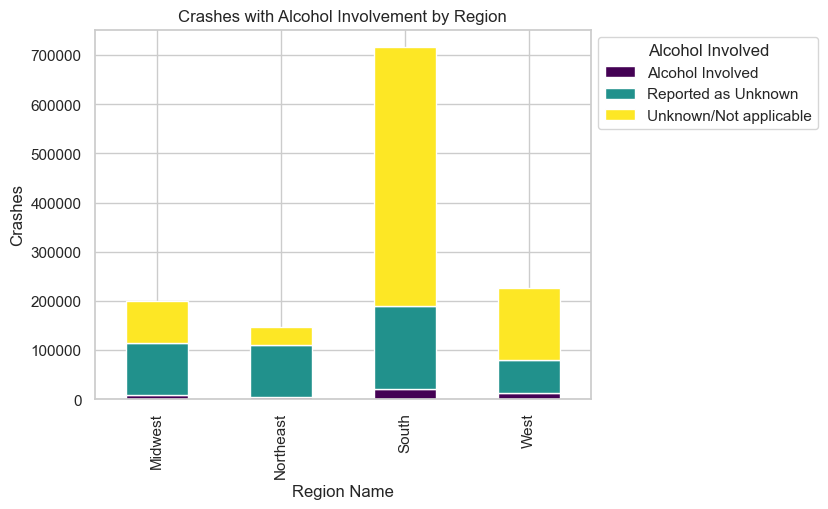

In [156]:
pivot_table = analysis_data.pivot_table(index='REGIONNAME', columns='ALCOHOL_INV', aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 6))
pivot_table.plot(kind='bar', stacked=True, cmap='viridis')
plt.title('Crashes with Alcohol Involvement by Region')
plt.xlabel('Region Name')
plt.ylabel('Crashes')
plt.legend(title='Alcohol Involved', bbox_to_anchor=(1, 1))
plt.show()

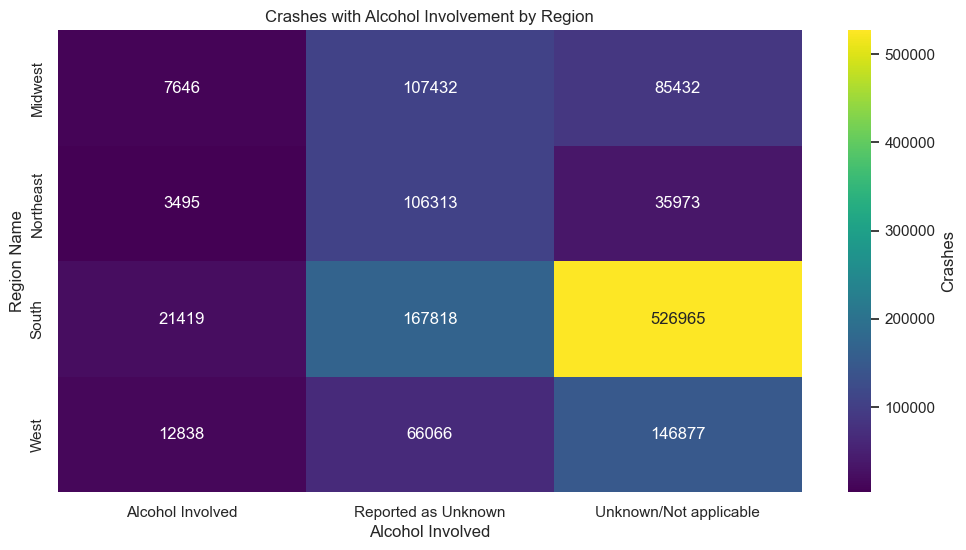

In [157]:
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='viridis', cbar_kws={'label': 'Crashes'})
plt.title('Crashes with Alcohol Involvement by Region')
plt.xlabel('Alcohol Involved')
plt.ylabel('Region Name')
plt.show()

<Figure size 1800x600 with 0 Axes>

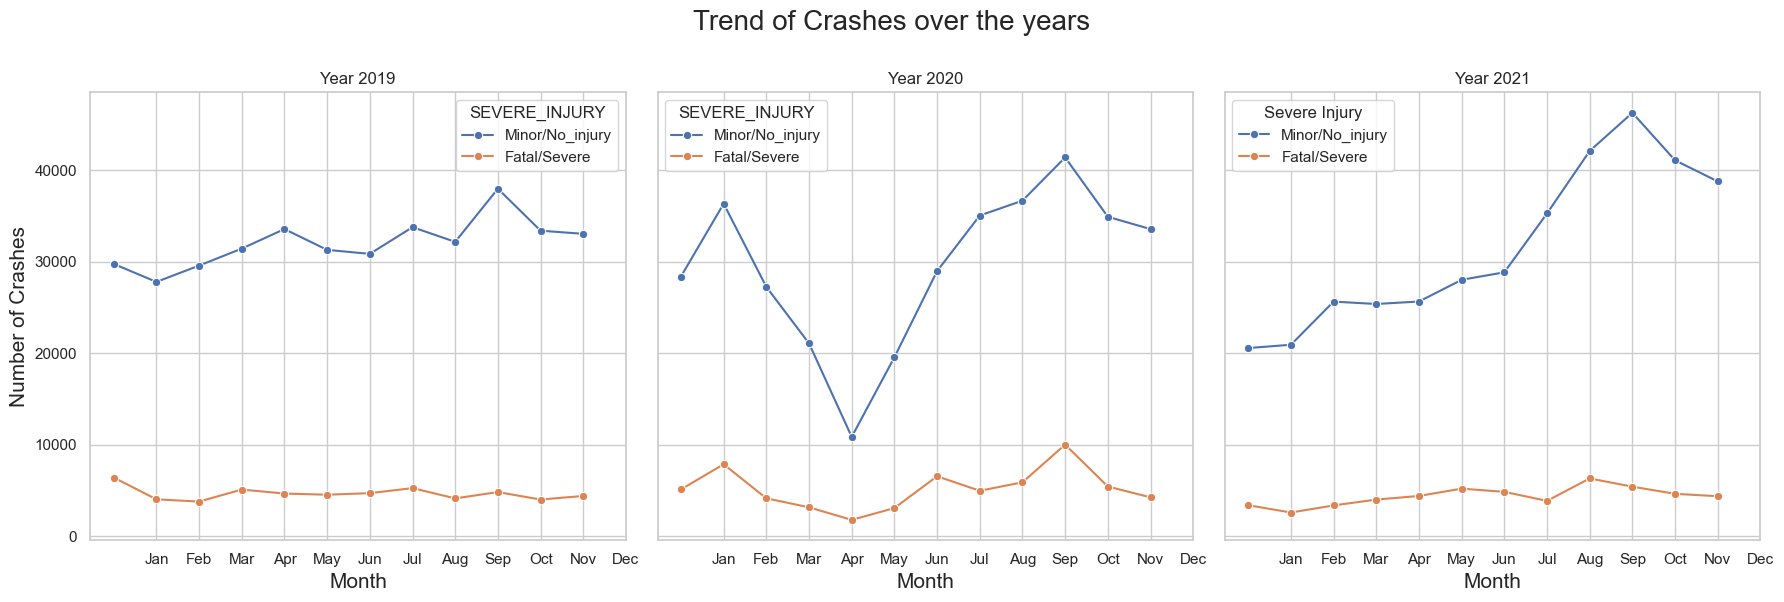

In [158]:
plt.figure(figsize=(18, 6))

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Trend of Crashes over the years',y=1,fontsize=20)

for i,year in enumerate(analysis_data['YEAR'].unique()):
    ax = axes[i]
    year_data=analysis_data[analysis_data['YEAR'] == year]
    sns.lineplot(data=year_data, x='MONTHNAME', y='CASENUM', hue='SEVERE_INJURY', estimator='count', errorbar=None, marker='o', ax=ax)
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Month',fontsize=15)
    ax.set_ylabel('Number of Crashes',fontsize=15)
    ax.set_xticks(range(1, 13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

axes[-1].legend(title='Severe Injury')

plt.tight_layout()
plt.show()


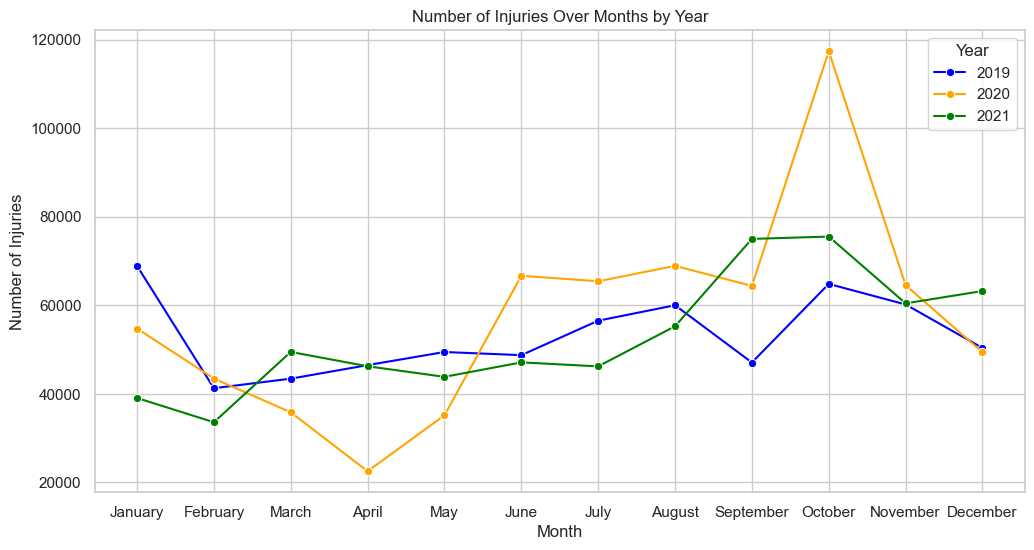

In [159]:

plt.figure(figsize=(12, 6))


sns.lineplot(data=analysis_data, x='MONTHNAME', y='NUM_INJ', hue='YEAR', estimator='sum', marker='o',errorbar=None,palette=['blue','orange','green'])

plt.title('Number of Injuries Over Months by Year')
plt.xlabel('Month')
plt.ylabel('Number of Injuries')

plt.legend(title='Year', loc='upper right')

plt.show()


In [160]:
analysis_data['SEVERE_INJURY'].unique()

array(['Minor/No_injury', 'Fatal/Severe'], dtype=object)

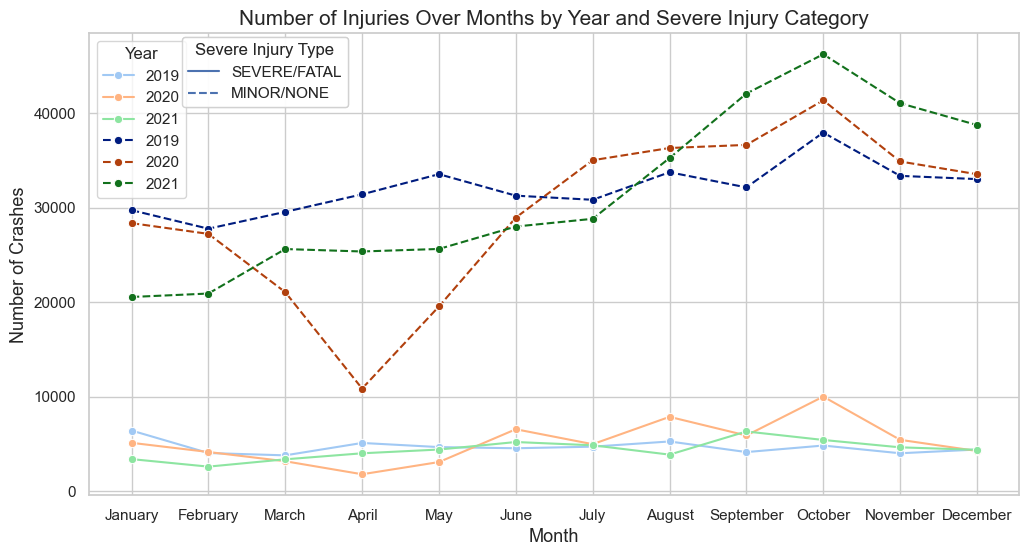

In [161]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=analysis_data[analysis_data['SEVERE_INJURY'] == 'Fatal/Severe'], x='MONTHNAME', y='CASENUM',
             hue='YEAR', estimator='count', errorbar=None, marker='o', palette='pastel')
sns.lineplot(data=analysis_data[analysis_data['SEVERE_INJURY'] == 'Minor/No_injury'], x='MONTHNAME', y='CASENUM',
             hue='YEAR', estimator='count', errorbar=None, linestyle='dashed', marker='o', palette='dark')


plt.title('Number of Injuries Over Months by Year and Severe Injury Category', fontsize = 15)
plt.xlabel('Month', fontsize=13)
plt.ylabel('Number of Crashes',fontsize = 13)

legend_year=plt.legend(title='Year', loc='upper left')
legend_severe_injury=plt.legend(
    handles=[
        Line2D([0], [0], label='SEVERE/FATAL'),
        Line2D([0], [0], label='MINOR/NONE', linestyle='dashed')
    ],
    title='Severe Injury Type', loc=(0.1,0.84)
)

plt.gca().add_artist(legend_severe_injury)
plt.gca().add_artist(legend_year)

plt.show()


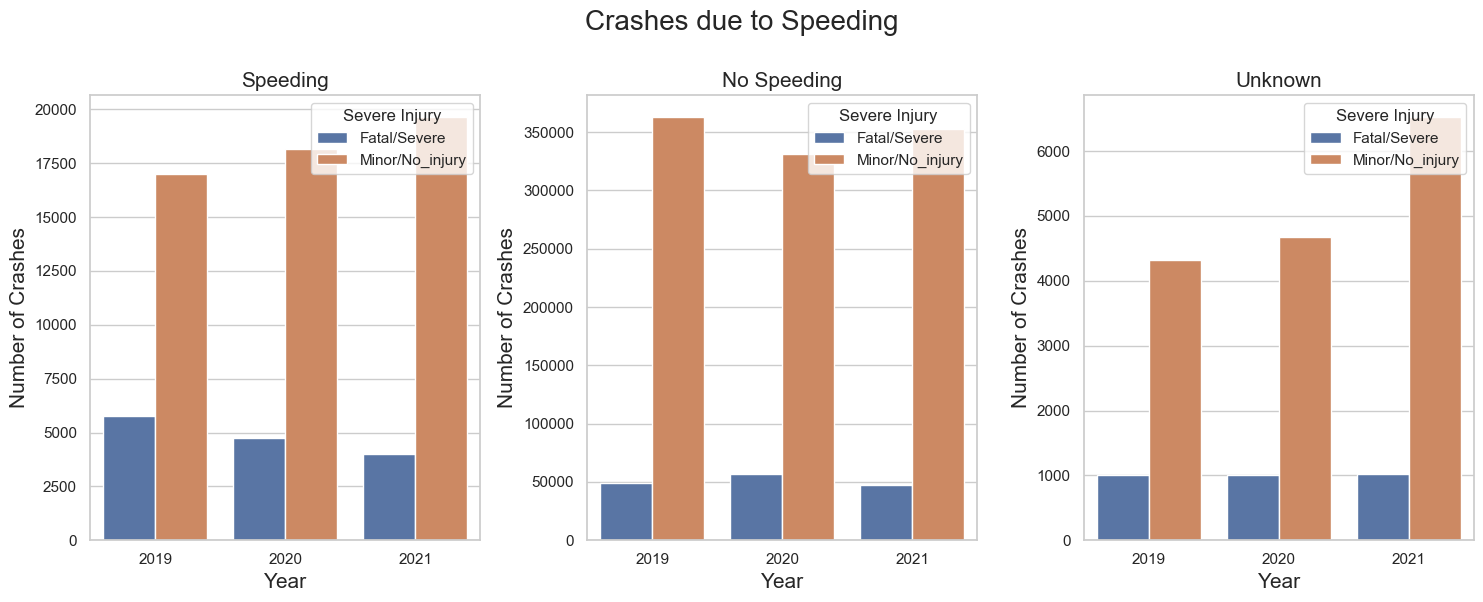

In [162]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
fig.suptitle('Crashes due to Speeding',y=1,fontsize=20)

for idx, speed_category in enumerate(analysis_data['SPEEDREL'].unique()):
   
    subset_data = analysis_data[analysis_data['SPEEDREL'] == speed_category]

    counts = subset_data.groupby(['YEAR', 'SEVERE_INJURY']).size().reset_index(name='COUNT')

    sns.barplot(data=counts, x='YEAR', y='COUNT', hue='SEVERE_INJURY', ax=axes[idx])

    axes[idx].set_title(f'{speed_category}',fontsize=15)
    axes[idx].set_xlabel('Year',fontsize=15)
    axes[idx].set_ylabel('Number of Crashes',fontsize=15)
    axes[idx].legend(title='Severe Injury', loc='upper right')
   
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [163]:
pivot_table = pd.pivot_table(
    analysis_data,
    values='CASENUM',
    index=['AGE_GROUP'],
    columns=['YEAR'],
    aggfunc='count'
)

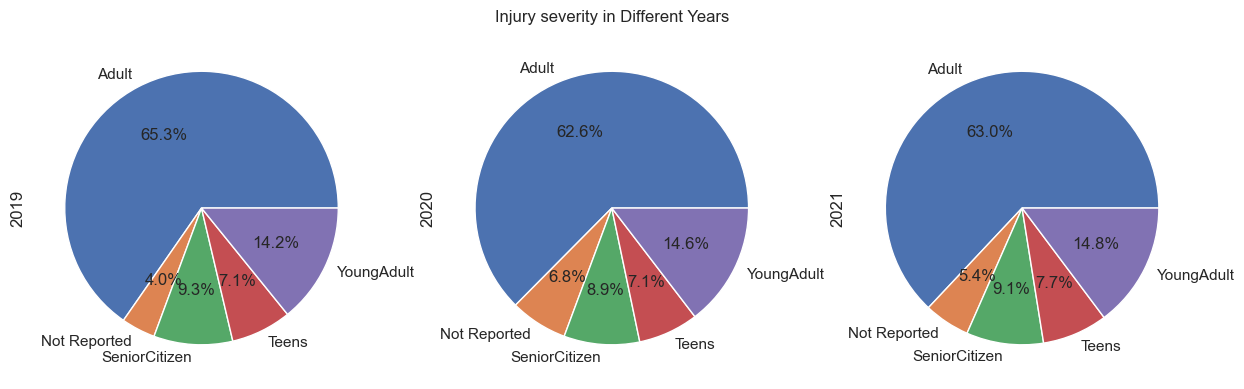

In [164]:
pivot_table.plot(kind='pie', subplots=True, figsize=(15, 6), legend=None,autopct='%1.1f%%')
plt.title('Injury severity in Different Years',y=1.02,x=-0.7)
plt.show()

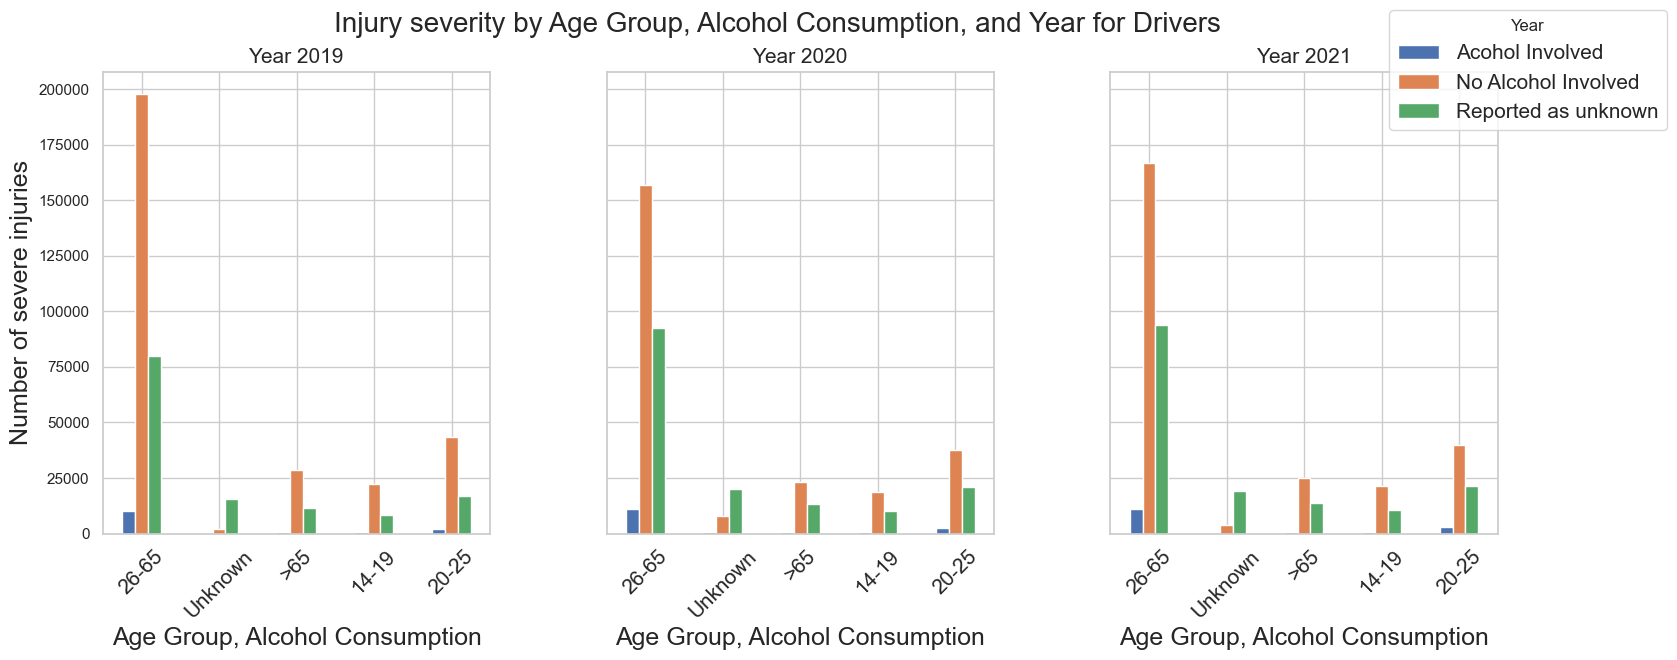

In [165]:
filtered_df = analysis_data[analysis_data['PER_TYP'] == 1]

years = [2019, 2020, 2021]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, year in enumerate(years):
    year_datetime = pd.to_datetime(str(year))
    year_data = filtered_df[filtered_df['YEAR']==year]
    
    pivot_table = pd.pivot_table(year_data, values='CASENUM', index=['AGE_GROUP', 'ALCOHOLNAME'], aggfunc='count')
    # print(pivot_table)
    
    pivot_table.unstack().plot(kind='bar', ax=axes[i], legend=False)
    axes[i].set_title(f'Year {year}',fontsize=15)
    axes[i].set_xlabel('Age Group, Alcohol Consumption',fontsize=18)
    axes[i].set_ylabel('Number of severe injuries',fontsize=18)
    axes[i].set_xticks(range(5),['26-65','Unknown','>65','14-19','20-25'],rotation=45, fontsize=15)

fig.legend(['Acohol Involved', 'No Alcohol Involved', 'Reported as unknown'],title='Year', loc='upper right',fontsize=15)
plt.subplots_adjust(wspace=0.3)  # Adjust the space between subplots
plt.suptitle('Injury severity by Age Group, Alcohol Consumption, and Year for Drivers', fontsize=20)
plt.show()


In [166]:
pivot_table = pd.pivot_table(analysis_data, values='CASENUM', index='REST_MIS', columns='YEAR', aggfunc='count')
pivot_table

YEAR,2019,2020,2021
REST_MIS,,,
Misued/Not_Used,50597,60145,58125
No Misuse,390091,356319,372997


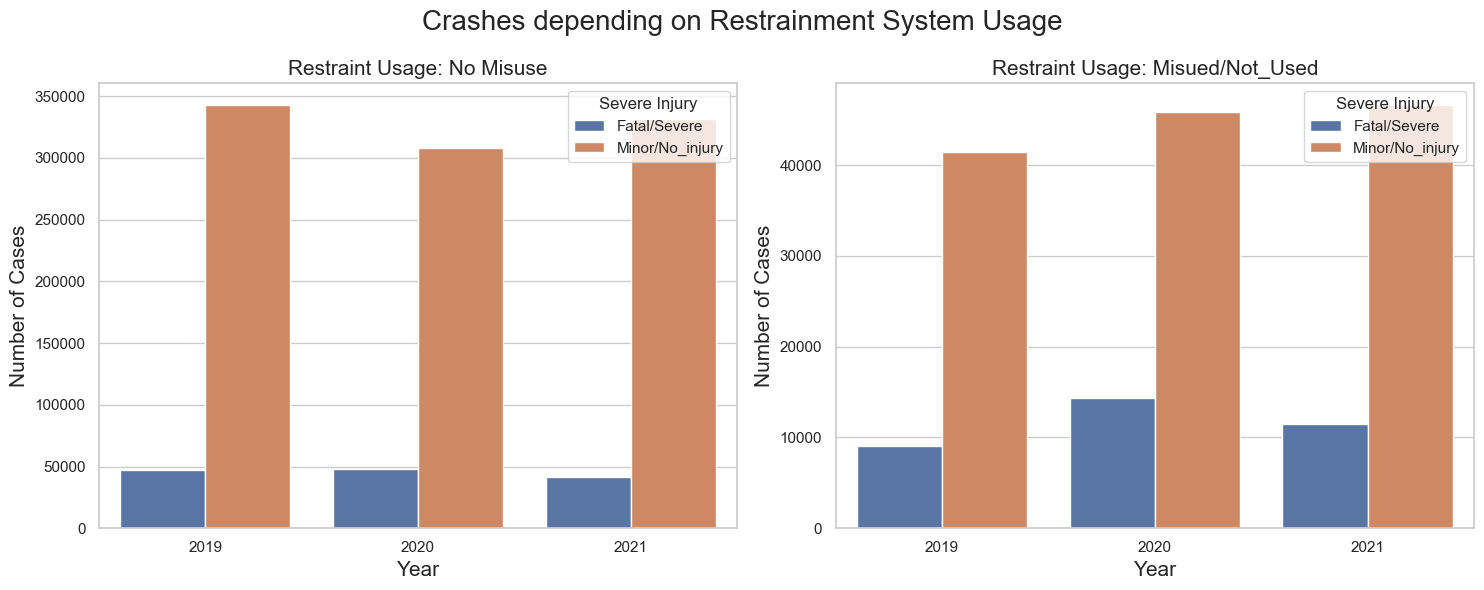

In [167]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.suptitle('Crashes depending on Restrainment System Usage',fontsize=20)

for idx, rest_mis_category in enumerate(analysis_data['REST_MIS'].unique()):
   
    subset_data = analysis_data[analysis_data['REST_MIS'] == rest_mis_category]
    counts = subset_data.groupby(['YEAR', 'SEVERE_INJURY']).size().reset_index(name='COUNT')
    sns.barplot(data=counts, x='YEAR', y='COUNT', hue='SEVERE_INJURY', ax=axes[idx])
    axes[idx].set_title(f'Restraint Usage: {rest_mis_category}',fontsize=15)
    axes[idx].set_xlabel('Year',fontsize=15)
    axes[idx].set_ylabel('Number of Cases',fontsize=15)
    axes[idx].legend(title='Severe Injury', loc='upper right')

plt.tight_layout()

plt.show()


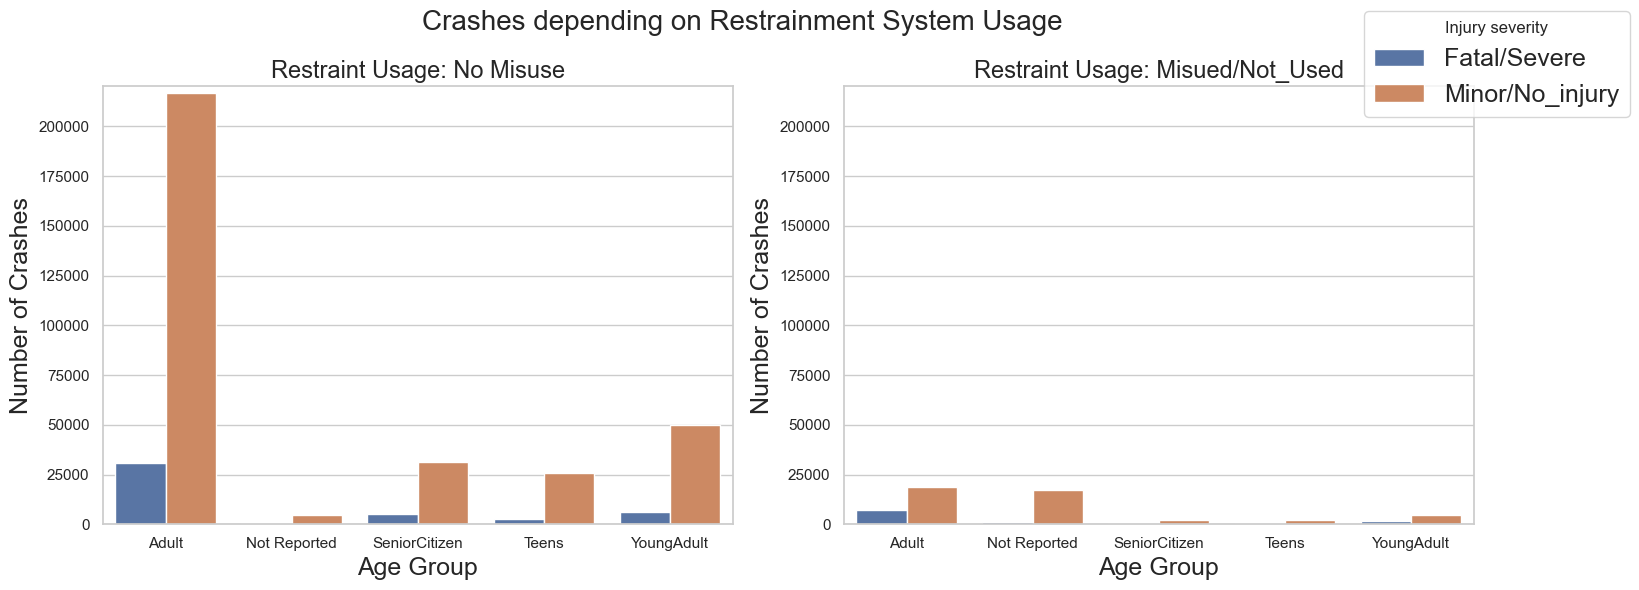

In [168]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.suptitle('Crashes depending on Restrainment System Usage',fontsize=20)
for idx, rest_mis_category in enumerate(analysis_data['REST_MIS'].unique()):
    subset_data = analysis_data[analysis_data['REST_MIS'] == rest_mis_category]

    counts = subset_data.groupby(['YEAR', 'AGE_GROUP', 'SEVERE_INJURY']).size().reset_index(name='COUNT')

    sns.barplot(data=counts, x='AGE_GROUP', y='COUNT', hue='SEVERE_INJURY', ax=axes[idx],errorbar=None)

    axes[idx].set_title(f'Restraint Usage: {rest_mis_category}',fontsize=17)
    axes[idx].set_xlabel('Age Group',fontsize=18)
    axes[idx].set_ylabel('Number of Crashes',fontsize=18)
    axes[idx].set_ylim(0,220000)
    axes[idx].legend().remove()

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title='Injury severity', loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18)

plt.tight_layout()

plt.show()


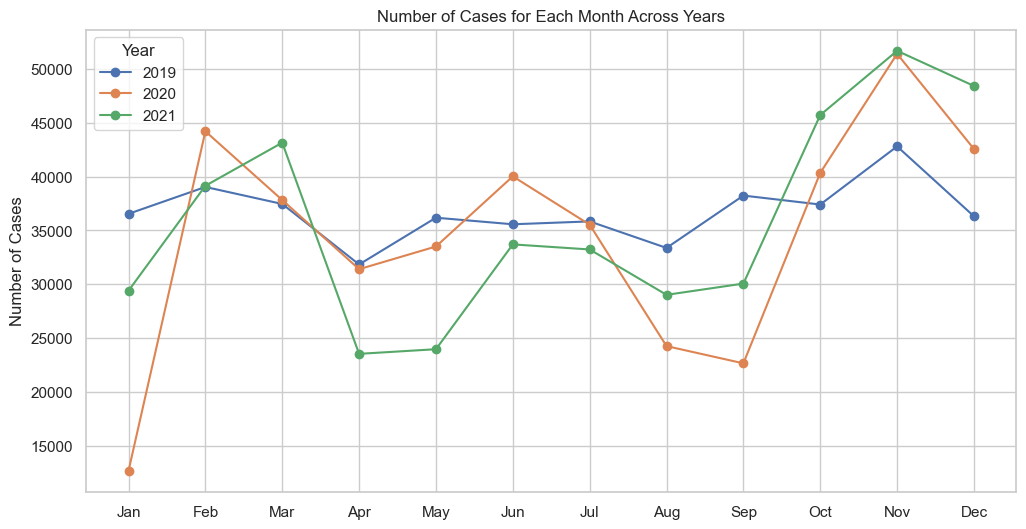

In [169]:
analysis_data_reset = analysis_data.reset_index()

monthly_counts = analysis_data_reset.groupby(['YEAR', 'MONTHNAME'])['CASENUM'].count().reset_index(name='CASE_COUNT')

plt.figure(figsize=(12, 6))
for year, data in monthly_counts.groupby('YEAR'):
    plt.plot(data['MONTHNAME'], data['CASE_COUNT'], label=str(year), marker='o')
plt.ylabel('Number of Cases')
months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(12), months_order)

plt.title('Number of Cases for Each Month Across Years')

plt.legend(title='Year')
plt.show()


<Figure size 1800x600 with 0 Axes>

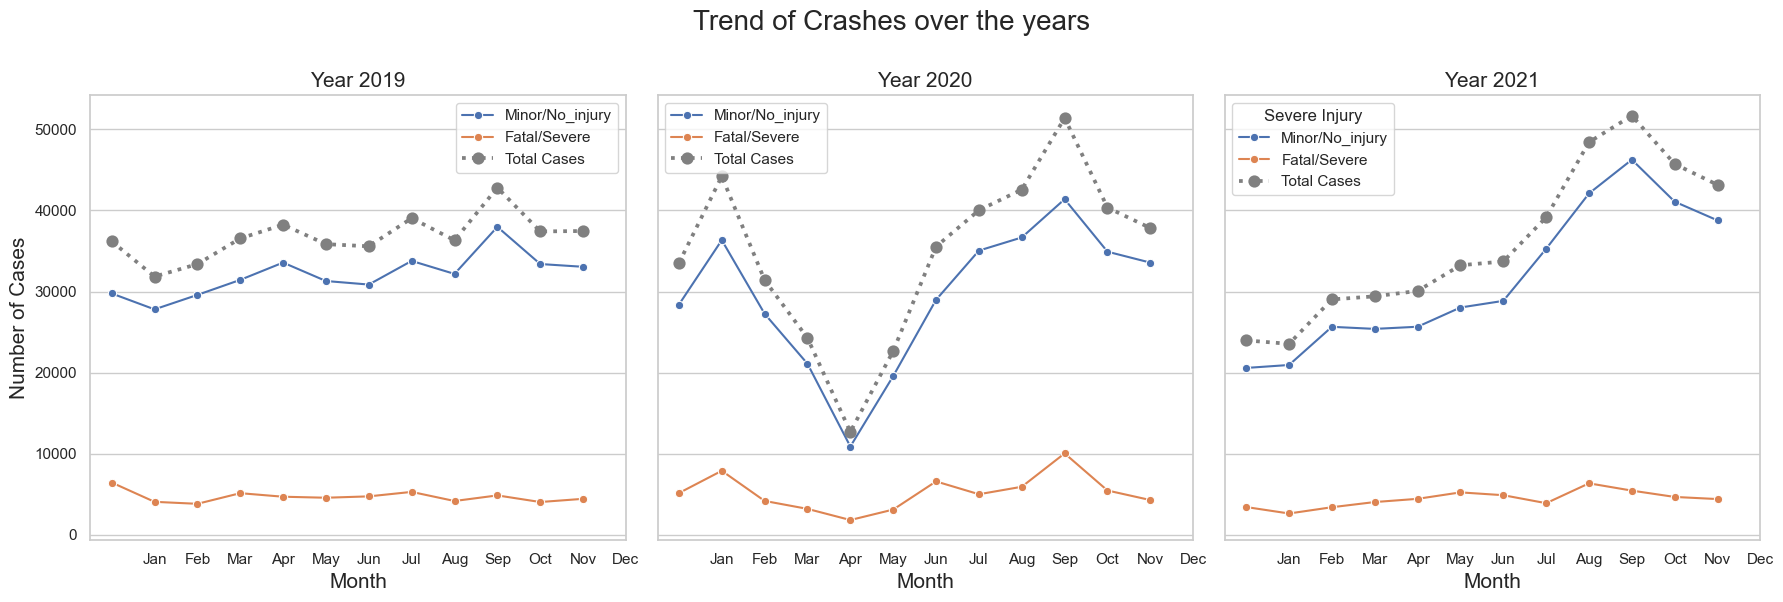

In [170]:

plt.figure(figsize=(18, 6))

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Trend of Crashes over the years',y=1,fontsize=20)
for i, year in enumerate(analysis_data['YEAR'].unique()):
    ax = axes[i]
    year_data = analysis_data[analysis_data['YEAR'] == year]
    sns.lineplot(data=year_data, x='MONTHNAME', y='CASENUM', hue='SEVERE_INJURY', estimator='count', errorbar=None, marker='o', ax=ax)
    
    total_cases_per_month = year_data.groupby('MONTHNAME')['CASENUM'].count().reset_index()
    sns.pointplot(x='MONTHNAME', y='CASENUM', data=total_cases_per_month, color='.5', ax=ax, linestyle='dotted', markers='o', label='Total Cases')
    
    
    ax.set_title(f'Year {year}',fontsize=15)
    ax.set_xlabel('Month',fontsize=15)
    ax.set_ylabel('Number of Cases',fontsize=15)
    ax.set_xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

axes[-1].legend(title='Severe Injury')

plt.tight_layout()

plt.show()  


<Figure size 1200x800 with 0 Axes>

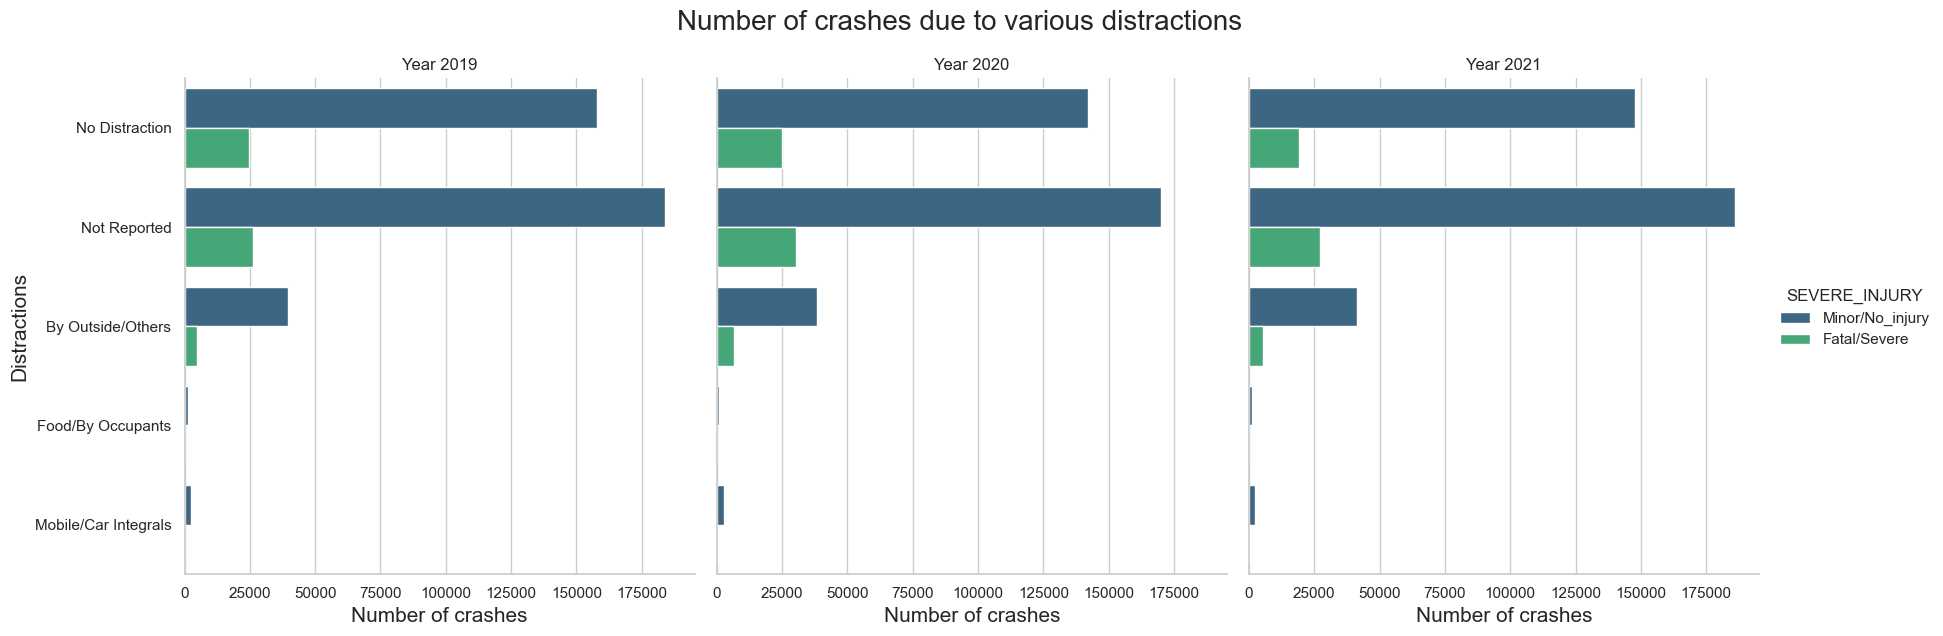

In [171]:

plt.figure(figsize=(12, 8))
catplot = sns.catplot(y='DIST_NAME', hue='SEVERE_INJURY', col='YEAR', kind='count', data=analysis_data, height=6, aspect=1, palette='viridis',orient='h')

catplot.set_titles('Year {col_name}')
catplot.set_axis_labels('Number of crashes','Distractions',fontsize=15)

catplot.fig.suptitle('Number of crashes due to various distractions',y=1.05,fontsize=20)
plt.show()


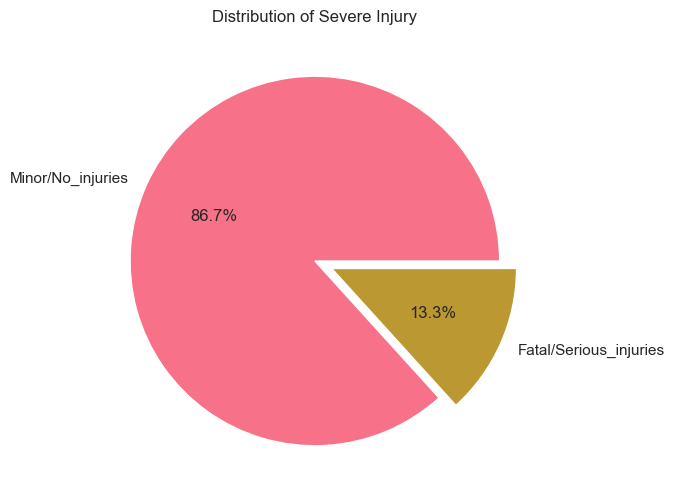

In [172]:
plt.figure(figsize=(6, 6))
sns.set(style="whitegrid")  # Optional: Set a white grid background for better visualization
severe_injury_counts = analysis_data['SEVERE_INJURY'].value_counts()
explode=[0,0.1]
plt.pie(severe_injury_counts, labels=['Minor/No_injuries','Fatal/Serious_injuries'], autopct='%1.1f%%',explode=explode, colors=sns.color_palette('husl'))

plt.title('Distribution of Severe Injury')
plt.show()


In [173]:
values = ['CASENUM']
index = 'AGE_GROUP'
columns = 'ALCOHOLNAME'
pivot_table = pd.pivot_table(analysis_data, values=values, index=index, columns=columns, aggfunc='count', fill_value=0,margins=True)

pivot_table.columns = [f'Number of Cases - {col}' for col in pivot_table.columns]
pivot_table



,"Number of Cases - ('CASENUM', 'Alcohol Involved')","Number of Cases - ('CASENUM', 'No Alcohol Involved')","Number of Cases - ('CASENUM', 'Reported as Unknown')","Number of Cases - ('CASENUM', 'All')"
AGE_GROUP,,,,
Adult,32449,521634,265944,820027
Not Reported,1267,13456,54587,69310
SeniorCitizen,2234,77022,38362,117618
Teens,2379,62726,29302,94407
YoungAdult,7069,120409,59434,186912
All,45398,795247,447629,1288274


In [174]:
# pivot_table = pd.pivot_table(analysis_data, values='CASENUM', index='AGE_GROUP', aggfunc='count')

# pivot_table

### Correlation analysis for categorical variables

In [175]:
analysis_data.columns

Index(['CASENUM', 'YEAR', 'REGION', 'REGIONNAME', 'NUM_INJ', 'MONTH',
       'MONTHNAME', 'DAY_WEEKNAME', 'ALCOHOLNAME', 'MAX_SEV', 'MAX_SEVNAME',
       'WEATHERNAME', 'AGE', 'PER_TYP', 'REST_MIS', 'SPEEDREL',
       'DRDISTRACTNAME', 'SEVERE_INJURY', 'AGE_GROUP', 'DIST_NAME',
       'DIST_NAME_', 'WEATHER_CND', 'ALCOHOL_INV'],
      dtype='object')

In [176]:
corr_data = analysis_data[['REGIONNAME',
       'MONTHNAME', 'DAY_WEEKNAME', 'ALCOHOL_INV',
        'WEATHER_CND','REST_MIS', 'SPEEDREL',
       'DIST_NAME', 'SEVERE_INJURY', 'AGE_GROUP',"PER_TYP"]]
corr_data=corr_data[corr_data['PER_TYP']==1]
corr_data = corr_data[['REGIONNAME',
       'MONTHNAME', 'DAY_WEEKNAME', 'ALCOHOL_INV',
        'WEATHER_CND','REST_MIS', 'SPEEDREL',
       'DIST_NAME', 'SEVERE_INJURY', 'AGE_GROUP',]]

In [177]:
correlation_matrix = associations(corr_data,
                                  nominal_columns=['REGIONNAME',
       'MONTHNAME', 'DAY_WEEKNAME', 'ALCOHOL_INV',
        'WEATHER_CND','REST_MIS', 'SPEEDREL',
       'DIST_NAME', 'SEVERE_INJURY', 'AGE_GROUP',],
                                  compute_only=True)["corr"] 
correlation_matrix

,REGIONNAME,MONTHNAME,DAY_WEEKNAME,ALCOHOL_INV,WEATHER_CND,REST_MIS,SPEEDREL,DIST_NAME,SEVERE_INJURY,AGE_GROUP
REGIONNAME,1.000000,0.044515,0.015593,0.260692,0.138510,0.049344,0.112856,0.243136,0.060979,0.030283
MONTHNAME,0.044515,1.000000,0.031210,0.027556,0.087216,0.033557,0.030518,0.018765,0.042059,0.026407
DAY_WEEKNAME,0.015593,0.031210,1.000000,0.071962,0.021393,0.054960,0.018396,0.011913,0.058452,0.020020
ALCOHOL_INV,0.260692,0.027556,0.071962,1.000000,0.053978,0.189310,0.053955,0.066647,0.147357,0.158197
WEATHER_CND,0.138510,0.087216,0.021393,0.053978,1.000000,0.050937,0.053727,0.023715,0.018118,0.016322
REST_MIS,0.049344,0.033557,0.054960,0.189310,0.050937,1.000000,0.071866,0.075030,0.084411,0.465154
SPEEDREL,0.112856,0.030518,0.018396,0.053955,0.053727,0.071866,1.000000,0.065079,0.055392,0.048235
DIST_NAME,0.243136,0.018765,0.011913,0.066647,0.023715,0.075030,0.065079,1.000000,0.009239,0.044214
SEVERE_INJURY,0.060979,0.042059,0.058452,0.147357,0.018118,0.084411,0.055392,0.009239,1.000000,0.050283
AGE_GROUP,0.030283,0.026407,0.020020,0.158197,0.016322,0.465154,0.048235,0.044214,0.050283,1.000000


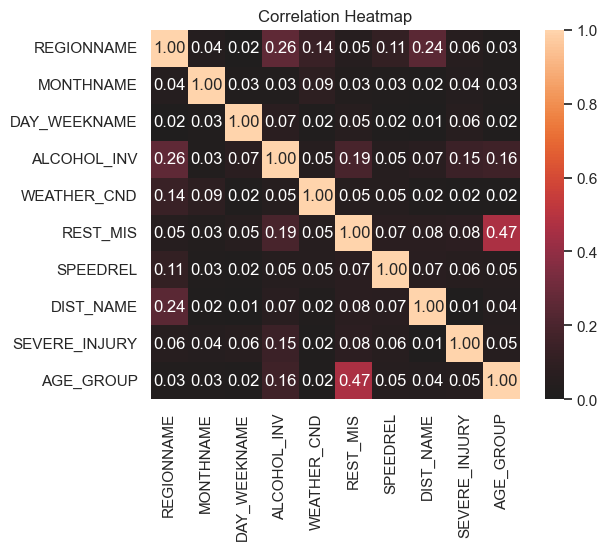

In [178]:
corr_plot = associations(corr_data, compute_only=False,title='Correlation Heatmap')["corr"] 

#### correlation checks for variables (optional)

In [57]:
# import scipy.stats as stats

In [58]:
# def chi_sqr_test(x,y):
#     ct = pd.crosstab(index=analysis_data[x], columns=analysis_data[y])
#     chi_test= stats.chi2_contingency(ct,)
#     # print(x,'||',y,'||',chi_test[1],'||', "correlated" if (chi_test[1]<0.05) else "Not_correlated")
#     print(chi_test)
#     print('____________________________________________________________________________________________________________________')

In [59]:
# def chi_sqr_test(x, y, data):
#     ct = pd.crosstab(data[x], data[y])
#     g, p = stats.power_divergence(ct, lambda_="log-likelihood")
#     result = "Correlated" if p < 0.05 else "Not Correlated"
#     print(f'{x} || {y} || p-value: {p} || {result}')
    
#     # x = stats.chi2_contingency(ct)
#     # print(x)
#     # # print(f'{x} || {y} || p-value: {p} || {"Correlated" if p < 0.05 else "Not Correlated"}')
#     print('---------------------------------------------------------------------')

In [60]:
# column_list= ['REGIONNAME',
#        'MONTHNAME', 'DAY_WEEKNAME', 'ALCOHOLNAME',
#         'WEATHERNAME','REST_MIS', 'SPEEDREL',
#        'DRDISTRACTNAME', 'SEVERE_INJURY', 'AGE_GROUP'] 

In [61]:
# for col in column_list:
#     if col != 'SEVERE_INJURY':
#         chi_sqr_test('SEVERE_INJURY',col)
                     
        

### Test Train split

In [62]:
!pip install -U imbalanced-learn
!pip install imblearn

In [63]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedKFold, RandomizedSearchCV
from sklearn import metrics
from scipy.stats import randint

In [64]:
y = analysis_data[['SEVERE_INJURY']].copy()
features_df = analysis_data[['YEAR', 'REGIONNAME', 'MONTHNAME', 'DAY_WEEKNAME', 'ALCOHOLNAME', 'REST_MIS', 'SPEEDREL', 'AGE_GROUP', 'DIST_NAME', 'WEATHER_CND']].copy()
features_df['YEAR'] = features_df['YEAR'].astype(str)


In [65]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288274 entries, 0 to 1288273
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   YEAR          1288274 non-null  object
 1   REGIONNAME    1288274 non-null  object
 2   MONTHNAME     1288274 non-null  object
 3   DAY_WEEKNAME  1288274 non-null  object
 4   ALCOHOLNAME   1288274 non-null  object
 5   REST_MIS      1288274 non-null  object
 6   SPEEDREL      1288274 non-null  object
 7   AGE_GROUP     1288274 non-null  object
 8   DIST_NAME     1288274 non-null  object
 9   WEATHER_CND   1288274 non-null  object
dtypes: object(10)
memory usage: 98.3+ MB


### model before resampling

In [66]:
REGIONNAME = pd.get_dummies(features_df['REGIONNAME'])
MONTHNAME = pd.get_dummies(features_df['MONTHNAME'])
DAY_WEEKNAME = pd.get_dummies(features_df['DAY_WEEKNAME'])
ALCOHOLNAME = pd.get_dummies(features_df['ALCOHOLNAME'])
REST_MIS = pd.get_dummies(features_df['REST_MIS'])
SPEEDREL = pd.get_dummies(features_df['SPEEDREL'])
AGE_GROUP = pd.get_dummies(features_df['AGE_GROUP'])
DIST_NAME = pd.get_dummies(features_df['DIST_NAME'])
WEATHER_CND = pd.get_dummies(features_df['WEATHER_CND'])
YEAR = pd.get_dummies(features_df['YEAR'])
# YEAR=features_df[['YEAR']]

In [67]:
X_original = pd.concat([YEAR,REGIONNAME,
       MONTHNAME, DAY_WEEKNAME, ALCOHOLNAME,REST_MIS, SPEEDREL,AGE_GROUP, DIST_NAME,WEATHER_CND],axis=1)
y_original=y

In [68]:
y_original[y_original == 'Fatal/Severe'] = 1
y_original[y_original == 'Minor/No_injury'] = 0
y_original = y_original.astype(int)
y_original = y_original.values.flatten()

In [69]:
print(X_original.shape,y_original.shape)

(1288274, 49) (1288274,)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.3, random_state=42)

In [71]:
logreg=LogisticRegression()
model0 = logreg.fit(X_train,y_train)

In [72]:
pred_model0 = model0.predict(X_test)
print(metrics.classification_report(y_test,pred_model0))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93    335259
           1       0.53      0.03      0.05     51224

    accuracy                           0.87    386483
   macro avg       0.70      0.51      0.49    386483
weighted avg       0.82      0.87      0.81    386483



In [73]:
X_test.shape

(386483, 49)

In [74]:
cm = metrics.confusion_matrix(y_test,pred_model0)
df_cm = pd.DataFrame(data=cm,
                    columns=['y^ Minor/No injury','y^ Fatal/Severe Injury'],
                     index=['y Minor/No injury','y Fatal/Severe Injury']
                    )
df_cm

,y^ Minor/No injury,y^ Fatal/Severe Injury
y Minor/No injury,334074,1185
y Fatal/Severe Injury,49904,1320


In [75]:
cv= RepeatedKFold(n_splits=5, random_state=798, n_repeats=10)
cross_val_score(model0, X_train, y_train, cv=cv, scoring='accuracy').mean()

0.8677206801230268

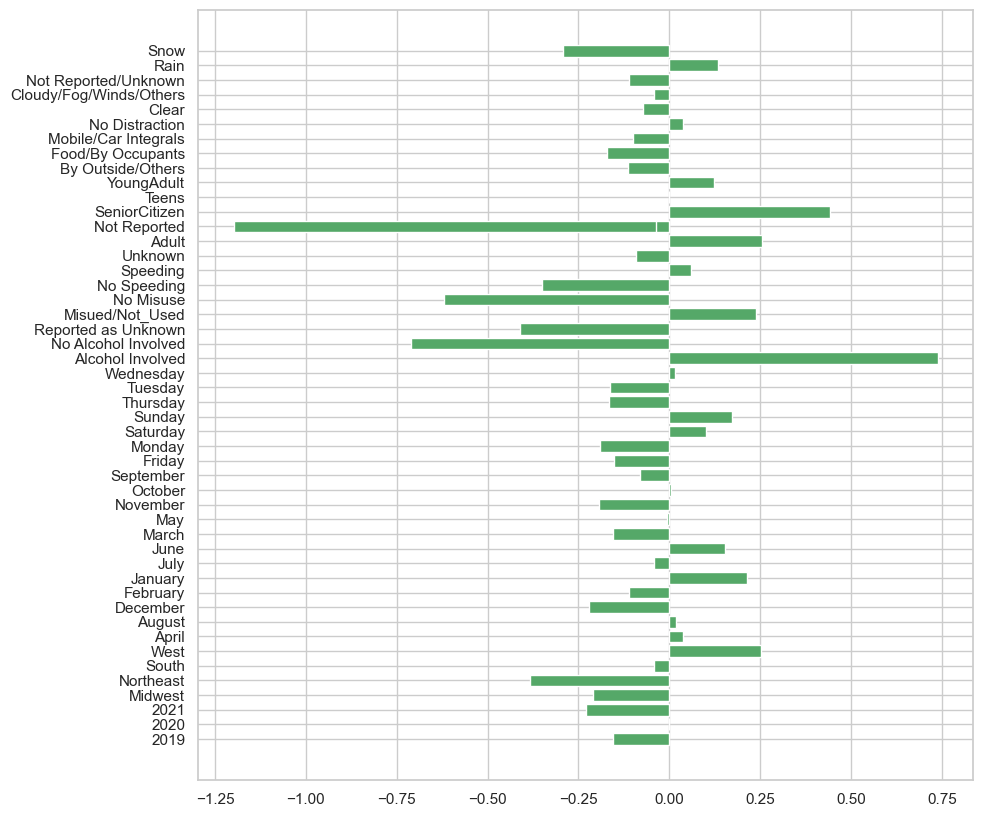

In [76]:
imp = model0.coef_.flatten()
plt.rcParams["figure.figsize"]=(10,10)
plt.barh(X_original.columns,imp,color="g")
plt.show()

In [77]:
RandF= RandomForestClassifier()

In [84]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
r_search = RandomizedSearchCV(RandF, 
                                 param_distributions = param_dist, 
                                 n_iter=3, 
                                 cv=5, random_state=49)

# Fit the random search object to the data
r_search.fit(X_train, y_train)
model0_RF = r_search.best_estimator_
print('Best hyperparameters:',  r_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 446}


In [85]:
pred_model0_RF = model0_RF.predict(X_test)
print(metrics.classification_report(y_test,pred_model0_RF))

              precision    recall  f1-score   support

           0       0.90      1.00      0.94    335259
           1       0.89      0.24      0.38     51224

    accuracy                           0.90    386483
   macro avg       0.89      0.62      0.66    386483
weighted avg       0.90      0.90      0.87    386483



#### After resampling 100%

In [86]:
y = analysis_data[['SEVERE_INJURY']].copy()
y.value_counts()

SEVERE_INJURY  
Minor/No_injury    1117254
Fatal/Severe        171020
dtype: int64

In [87]:
rus_100 = RandomUnderSampler(random_state=42)
features_resampled_100, y_resampled_100 = rus_100.fit_resample(features_df, y)
print(features_resampled_100.shape,y_resampled_100.shape)

(342040, 10) (342040, 1)


In [88]:
pd.DataFrame(y_resampled_100).value_counts()

SEVERE_INJURY  
Fatal/Severe       171020
Minor/No_injury    171020
dtype: int64

In [89]:
REGIONNAME = pd.get_dummies(features_resampled_100['REGIONNAME'])
MONTHNAME = pd.get_dummies(features_resampled_100['MONTHNAME'])
DAY_WEEKNAME = pd.get_dummies(features_resampled_100['DAY_WEEKNAME'])
ALCOHOLNAME = pd.get_dummies(features_resampled_100['ALCOHOLNAME'])
REST_MIS = pd.get_dummies(features_resampled_100['REST_MIS'])
SPEEDREL = pd.get_dummies(features_resampled_100['SPEEDREL'])
AGE_GROUP = pd.get_dummies(features_resampled_100['AGE_GROUP'])
DIST_NAME = pd.get_dummies(features_resampled_100['DIST_NAME'])
WEATHER_CND = pd.get_dummies(features_resampled_100['WEATHER_CND'])
YEAR = pd.get_dummies(features_resampled_100['YEAR'])

In [90]:
X_resampled_100 = pd.concat([YEAR,REGIONNAME,
       MONTHNAME, DAY_WEEKNAME, ALCOHOLNAME,REST_MIS, SPEEDREL,AGE_GROUP, DIST_NAME,WEATHER_CND],axis=1)

In [91]:
y_resampled_100[y_resampled_100 == 'Fatal/Severe'] = 1
y_resampled_100[y_resampled_100 == 'Minor/No_injury'] = 0
y_resampled_100 = y_resampled_100.astype(int)
y_resampled_100 = y_resampled_100.values.flatten()

In [92]:
print(X_resampled_100.shape,y_resampled_100.shape)

(342040, 49) (342040,)


In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_100, y_resampled_100, test_size=0.3, random_state=42)

In [94]:
print(X_train.shape,y_train.shape)

(239428, 49) (239428,)


In [95]:
logreg=LogisticRegression()

In [96]:
model1 = logreg.fit(X_train,y_train)

In [97]:
pred_model1 = model1.predict(X_test)

In [98]:
print(metrics.classification_report(y_test,pred_model1))

              precision    recall  f1-score   support

           0       0.59      0.71      0.64     51306
           1       0.64      0.52      0.57     51306

    accuracy                           0.61    102612
   macro avg       0.61      0.61      0.61    102612
weighted avg       0.61      0.61      0.61    102612



In [99]:
cv= RepeatedKFold(n_splits=5, random_state=798, n_repeats=10)
cross_val_score(model1, X_train, y_train, cv=cv, scoring='accuracy').mean()

0.609953725493613

In [100]:
cm = metrics.confusion_matrix(y_test,pred_model1)
df_cm = pd.DataFrame(data=cm,
                    columns=['y^ Minor/No injury','y^ Fatal/Severe Injury'],
                     index=['y Minor/No injury','y Fatal/Severe Injury']
                    )
df_cm

,y^ Minor/No injury,y^ Fatal/Severe Injury
y Minor/No injury,36172,15134
y Fatal/Severe Injury,24821,26485


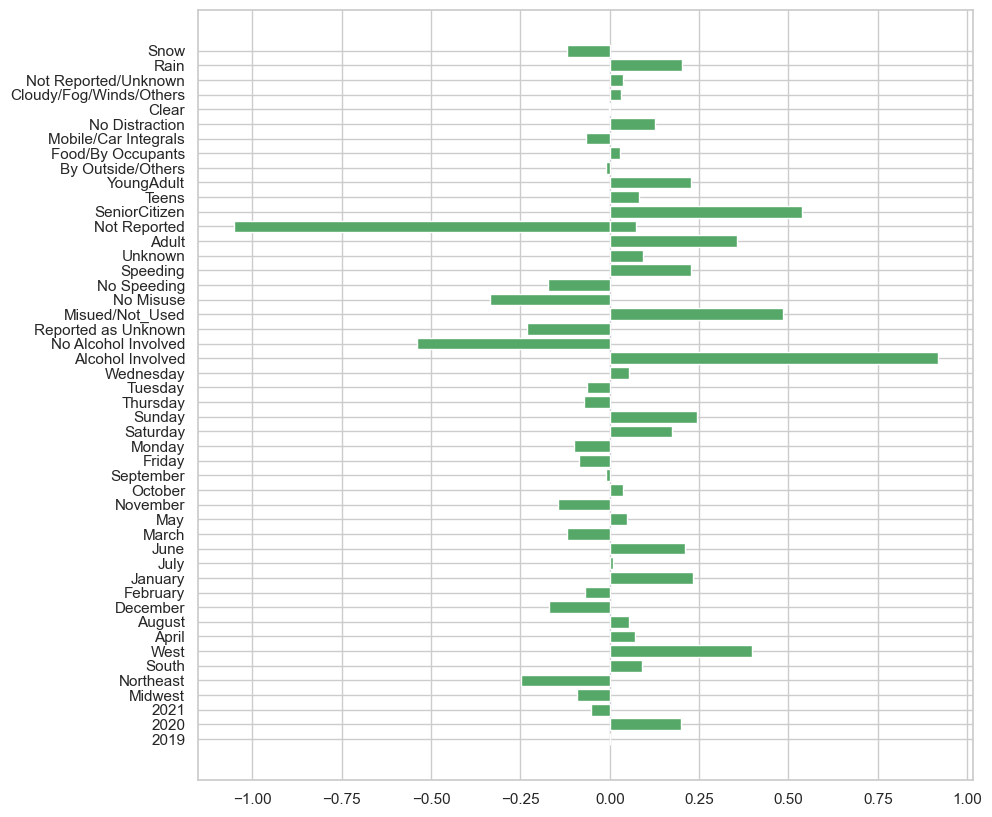

In [101]:
imp = model1.coef_.flatten()
plt.rcParams["figure.figsize"]=(10,10)
plt.barh(X_resampled_100.columns,imp,color="g")
plt.show()

In [102]:
# RandF= RandomForestClassifier()
# model1_RF= RandF.fit(X_train,y_train)
# pred_model1_RF = model1_RF.predict(X_test)
# print(metrics.classification_report(y_test,pred_model1_RF))

In [103]:
# cv= RepeatedKFold(n_splits=5, random_state=798, n_repeats=3)
# cross_val_score(model1_RF, X_train, y_train, cv=cv, scoring='accuracy').mean()

In [104]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
r_search = RandomizedSearchCV(RandF, 
                                 param_distributions = param_dist, 
                                 n_iter=3, 
                                 cv=5, random_state=49)

# Fit the random search object to the data
r_search.fit(X_train, y_train)
model1_RF = r_search.best_estimator_
print('Best hyperparameters:',  r_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 446}


In [105]:
pred_model1_RF = model1_RF.predict(X_test)
print(metrics.classification_report(y_test,pred_model1_RF))

              precision    recall  f1-score   support

           0       0.73      0.84      0.78     51306
           1       0.81      0.69      0.74     51306

    accuracy                           0.76    102612
   macro avg       0.77      0.76      0.76    102612
weighted avg       0.77      0.76      0.76    102612



#### Resampling with 75% down sampling

sampling_strategy(float),default=’auto’
Sampling information to sample the data set.

When float, it corresponds to the desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling. Therefore, the ratio is expressed as **Nm/NrM**

where, **NM** is the number of samples in the minority class and 
 **NrM** is the number of samples in the majority class after resampling.

In [106]:
rus_75 = RandomUnderSampler(sampling_strategy=0.75,random_state=42)
features_resampled_75, y_resampled_75 = rus_75.fit_resample(features_df, y)
print(features_resampled_75.shape,y_resampled_75.shape)

(399046, 10) (399046, 1)


In [107]:
pd.DataFrame(y_resampled_75).value_counts()

SEVERE_INJURY  
Minor/No_injury    228026
Fatal/Severe       171020
dtype: int64

In [108]:
REGIONNAME = pd.get_dummies(features_resampled_75['REGIONNAME'])
MONTHNAME = pd.get_dummies(features_resampled_75['MONTHNAME'])
DAY_WEEKNAME = pd.get_dummies(features_resampled_75['DAY_WEEKNAME'])
ALCOHOLNAME = pd.get_dummies(features_resampled_75['ALCOHOLNAME'])
REST_MIS = pd.get_dummies(features_resampled_75['REST_MIS'])
SPEEDREL = pd.get_dummies(features_resampled_75['SPEEDREL'])
AGE_GROUP = pd.get_dummies(features_resampled_75['AGE_GROUP'])
DIST_NAME = pd.get_dummies(features_resampled_75['DIST_NAME'])
WEATHER_CND = pd.get_dummies(features_resampled_75['WEATHER_CND'])
YEAR = pd.get_dummies(features_resampled_75['YEAR'])

In [109]:
X_resampled_75 = pd.concat([YEAR,REGIONNAME,
       MONTHNAME, DAY_WEEKNAME, ALCOHOLNAME,REST_MIS, SPEEDREL,AGE_GROUP, DIST_NAME,WEATHER_CND],axis=1)

In [110]:
y_resampled_75[y_resampled_75 == 'Fatal/Severe'] = 1
y_resampled_75[y_resampled_75 == 'Minor/No_injury'] = 0
y_resampled_75 = y_resampled_75.astype(int)
y_resampled_75 = y_resampled_75.values.flatten()

In [111]:
print(X_resampled_75.shape,y_resampled_75.shape)

(399046, 49) (399046,)


In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_75, y_resampled_75, test_size=0.3, random_state=42)

In [113]:
print(X_train.shape,y_train.shape)

(279332, 49) (279332,)


In [114]:
logreg=LogisticRegression()
model2 = logreg.fit(X_train,y_train)
pred_model2 = model2.predict(X_test)

In [115]:
print(metrics.classification_report(y_test,pred_model2))

              precision    recall  f1-score   support

           0       0.63      0.86      0.73     68453
           1       0.64      0.34      0.45     51261

    accuracy                           0.64    119714
   macro avg       0.64      0.60      0.59    119714
weighted avg       0.64      0.64      0.61    119714



In [116]:
cv= RepeatedKFold(n_splits=5, random_state=798, n_repeats=10)
cross_val_score(model2, X_train, y_train, cv=cv, scoring='accuracy').mean()

0.6337032622056633

In [117]:
cm = metrics.confusion_matrix(y_test,pred_model2)
df_cm = pd.DataFrame(data=cm,
                    columns=['y^ Minor/No injury','y^ Fatal/Severe Injury'],
                     index=['y Minor/No injury','y Fatal/Severe Injury']
                    )
df_cm

,y^ Minor/No injury,y^ Fatal/Severe Injury
y Minor/No injury,58617,9836
y Fatal/Severe Injury,33729,17532


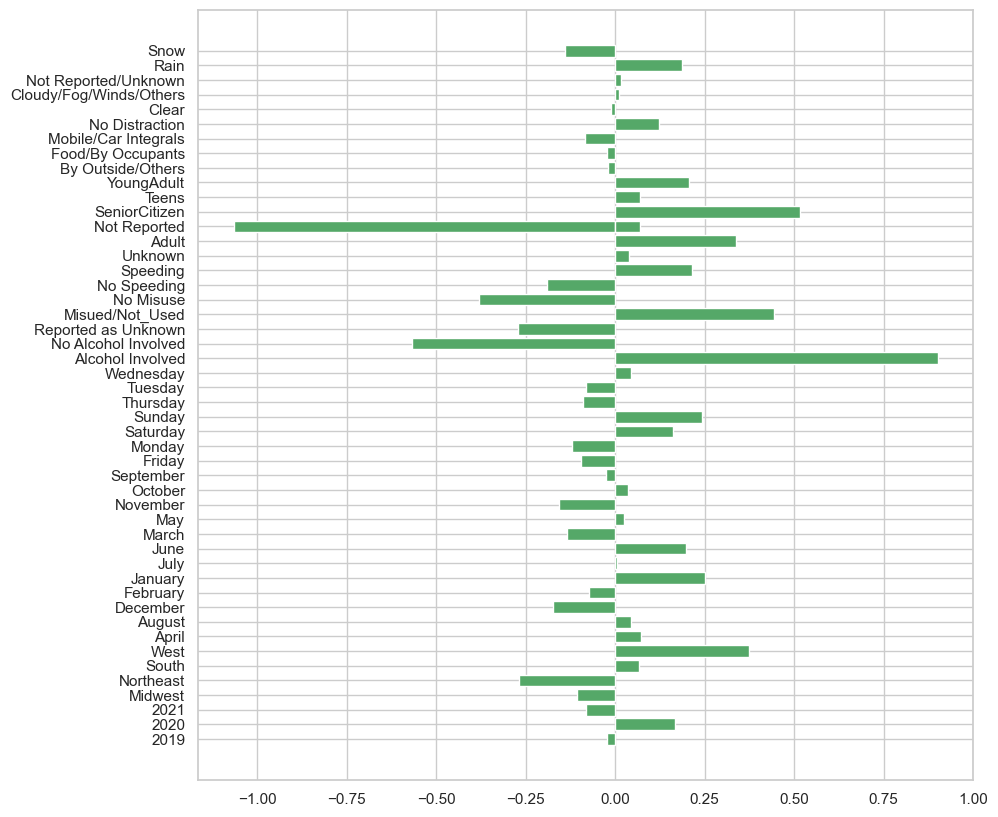

In [118]:
imp = model2.coef_.flatten()
plt.rcParams["figure.figsize"]=(10,10)
plt.barh(X_resampled_75.columns,imp,color="g")
plt.show()

In [119]:
# RandF= RandomForestClassifier()
# model2_RF= RandF.fit(X_train,y_train)
# pred_model2_RF = model2_RF.predict(X_test)
# print(metrics.classification_report(y_test,pred_model2_RF))

In [120]:
# cv= RepeatedKFold(n_splits=5, random_state=798, n_repeats=3)
# cross_val_score(model2_RF, X_train, y_train, cv=cv, scoring='accuracy').mean()

In [121]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
r_search = RandomizedSearchCV(RandF, 
                                 param_distributions = param_dist, 
                                 n_iter=3, 
                                 cv=5, random_state=49)

# Fit the random search object to the data
r_search.fit(X_train, y_train)
model2_RF = r_search.best_estimator_
print('Best hyperparameters:',  r_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 446}


In [122]:
pred_model2_RF = model2_RF.predict(X_test)
print(metrics.classification_report(y_test,pred_model2_RF))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82     68453
           1       0.83      0.59      0.69     51261

    accuracy                           0.77    119714
   macro avg       0.79      0.75      0.75    119714
weighted avg       0.78      0.77      0.76    119714



#### Resampling with 50% undersampling

In [123]:
rus_50 = RandomUnderSampler(sampling_strategy=0.50,random_state=42)
features_resampled_50, y_resampled_50 = rus_50.fit_resample(features_df, y)
print(features_resampled_50.shape,y_resampled_50.shape)

(513060, 10) (513060, 1)


In [124]:
pd.DataFrame(y_resampled_50).value_counts()

SEVERE_INJURY  
Minor/No_injury    342040
Fatal/Severe       171020
dtype: int64

In [125]:
REGIONNAME = pd.get_dummies(features_resampled_50['REGIONNAME'])
MONTHNAME = pd.get_dummies(features_resampled_50['MONTHNAME'])
DAY_WEEKNAME = pd.get_dummies(features_resampled_50['DAY_WEEKNAME'])
ALCOHOLNAME = pd.get_dummies(features_resampled_50['ALCOHOLNAME'])
REST_MIS = pd.get_dummies(features_resampled_50['REST_MIS'])
SPEEDREL = pd.get_dummies(features_resampled_50['SPEEDREL'])
AGE_GROUP = pd.get_dummies(features_resampled_50['AGE_GROUP'])
DIST_NAME = pd.get_dummies(features_resampled_50['DIST_NAME'])
WEATHER_CND = pd.get_dummies(features_resampled_50['WEATHER_CND'])
YEAR = pd.get_dummies(features_resampled_50['YEAR'])

In [126]:
X_resampled_50 = pd.concat([YEAR,REGIONNAME,
       MONTHNAME, DAY_WEEKNAME, ALCOHOLNAME,REST_MIS, SPEEDREL,AGE_GROUP, DIST_NAME,WEATHER_CND],axis=1)

In [127]:
y_resampled_50[y_resampled_50 == 'Fatal/Severe'] = 1
y_resampled_50[y_resampled_50 == 'Minor/No_injury'] = 0
y_resampled_50 = y_resampled_50.astype(int)
y_resampled_50 = y_resampled_50.values.flatten()

In [128]:
print(X_resampled_50.shape,y_resampled_50.shape)

(513060, 49) (513060,)


In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_50, y_resampled_50, test_size=0.3, random_state=42)

In [130]:
print(X_train.shape,y_train.shape)

(359142, 49) (359142,)


In [131]:
logreg=LogisticRegression()
model3 = logreg.fit(X_train,y_train)
pred_model3 = model3.predict(X_test)

In [132]:
print(metrics.classification_report(y_test,pred_model3))

              precision    recall  f1-score   support

           0       0.70      0.94      0.80    102668
           1       0.63      0.21      0.31     51250

    accuracy                           0.70    153918
   macro avg       0.67      0.57      0.56    153918
weighted avg       0.68      0.70      0.64    153918



In [133]:
cv= RepeatedKFold(n_splits=5, random_state=798, n_repeats=10)
cross_val_score(model3, X_train, y_train, cv=cv, scoring='accuracy').mean()

0.6964855139274724

In [134]:
cm = metrics.confusion_matrix(y_test,pred_model3)
df_cm = pd.DataFrame(data=cm,
                    columns=['y^ Minor/No injury','y^ Fatal/Severe Injury'],
                     index=['y Minor/No injury','y Fatal/Severe Injury']
                    )
df_cm

,y^ Minor/No injury,y^ Fatal/Severe Injury
y Minor/No injury,96444,6224
y Fatal/Severe Injury,40715,10535


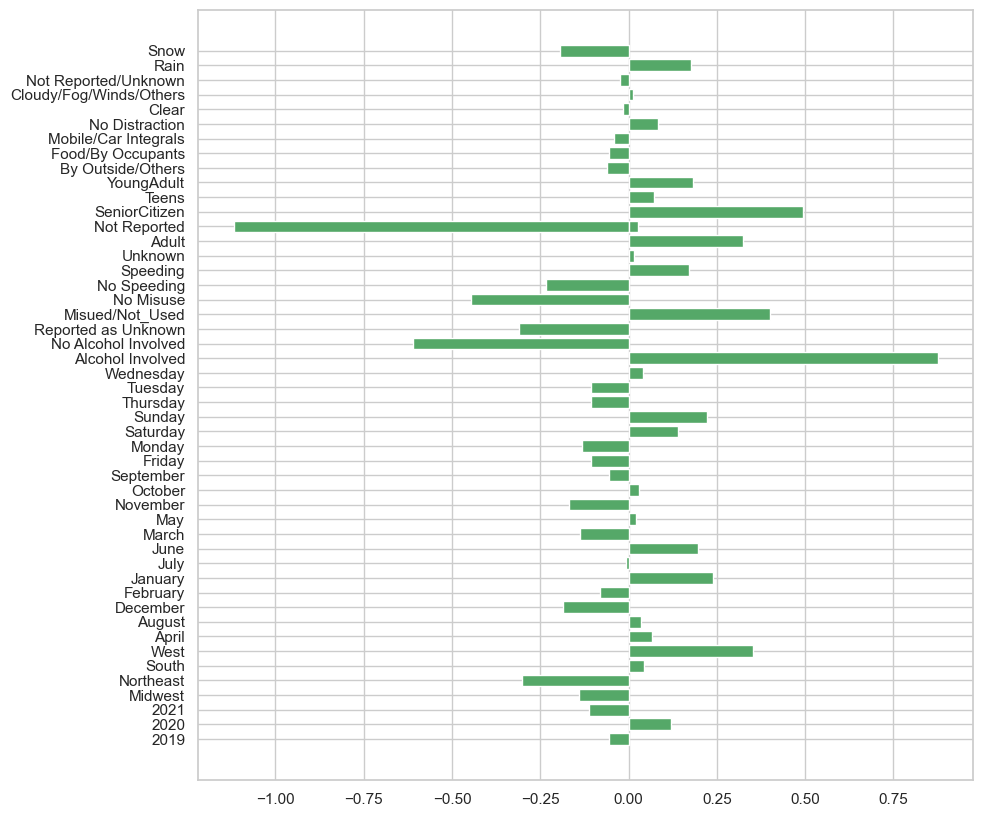

In [135]:
imp = model3.coef_.flatten()
plt.rcParams["figure.figsize"]=(10,10)
plt.barh(X_resampled_50.columns,imp,color="g")
plt.show()

In [136]:
# RandF= RandomForestClassifier()
# model3_RF= RandF.fit(X_train,y_train)
# pred_model3_RF = model3_RF.predict(X_test)
# print(metrics.classification_report(y_test,pred_model3_RF))

In [137]:
# cv= RepeatedKFold(n_splits=5, random_state=798, n_repeats=3)
# cross_val_score(model3_RF, X_train, y_train, cv=cv, scoring='accuracy').mean()

In [138]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
r_search = RandomizedSearchCV(RandF, 
                                 param_distributions = param_dist, 
                                 n_iter=3, 
                                 cv=5, random_state=49)

# Fit the random search object to the data
r_search.fit(X_train, y_train)
model3_RF = r_search.best_estimator_
print('Best hyperparameters:',  r_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 446}


In [139]:
pred_model3_RF = model3_RF.predict(X_test)
print(metrics.classification_report(y_test,pred_model3_RF))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86    102668
           1       0.84      0.46      0.60     51250

    accuracy                           0.79    153918
   macro avg       0.81      0.71      0.73    153918
weighted avg       0.80      0.79      0.77    153918



#### Resampling with 25% undersampling

In [140]:
rus_25 = RandomUnderSampler(sampling_strategy=0.25,random_state=42)
features_resampled_25, y_resampled_25 = rus_25.fit_resample(features_df, y)
print(features_resampled_25.shape,y_resampled_25.shape)

(855100, 10) (855100, 1)


In [141]:
pd.DataFrame(y_resampled_25).value_counts()

SEVERE_INJURY  
Minor/No_injury    684080
Fatal/Severe       171020
dtype: int64

In [142]:
REGIONNAME = pd.get_dummies(features_resampled_25['REGIONNAME'])
MONTHNAME = pd.get_dummies(features_resampled_25['MONTHNAME'])
DAY_WEEKNAME = pd.get_dummies(features_resampled_25['DAY_WEEKNAME'])
ALCOHOLNAME = pd.get_dummies(features_resampled_25['ALCOHOLNAME'])
REST_MIS = pd.get_dummies(features_resampled_25['REST_MIS'])
SPEEDREL = pd.get_dummies(features_resampled_25['SPEEDREL'])
AGE_GROUP = pd.get_dummies(features_resampled_25['AGE_GROUP'])
DIST_NAME = pd.get_dummies(features_resampled_25['DIST_NAME'])
WEATHER_CND = pd.get_dummies(features_resampled_25['WEATHER_CND'])
YEAR = pd.get_dummies(features_resampled_25['YEAR'])

In [143]:
X_resampled_25 = pd.concat([YEAR,REGIONNAME,
       MONTHNAME, DAY_WEEKNAME, ALCOHOLNAME,REST_MIS, SPEEDREL,AGE_GROUP, DIST_NAME,WEATHER_CND],axis=1)

In [144]:
y_resampled_25[y_resampled_25 == 'Fatal/Severe'] = 1
y_resampled_25[y_resampled_25 == 'Minor/No_injury'] = 0
y_resampled_25 = y_resampled_25.astype(int)
y_resampled_25 = y_resampled_25.values.flatten()

In [145]:
print(X_resampled_25.shape,y_resampled_25.shape)

(855100, 49) (855100,)


In [146]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_25, y_resampled_25, test_size=0.3, random_state=42)

In [147]:
print(X_train.shape,y_train.shape)

(598570, 49) (598570,)


In [148]:
logreg=LogisticRegression()
model4 = logreg.fit(X_train,y_train)
pred_model4 = model4.predict(X_test)

In [149]:
print(metrics.classification_report(y_test,pred_model4))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89    205298
           1       0.56      0.06      0.11     51232

    accuracy                           0.80    256530
   macro avg       0.69      0.52      0.50    256530
weighted avg       0.76      0.80      0.73    256530



In [150]:
cv= RepeatedKFold(n_splits=5, random_state=798, n_repeats=10)
cross_val_score(model4, X_train, y_train, cv=cv, scoring='accuracy').mean()

0.8027716056601567

In [151]:
cm = metrics.confusion_matrix(y_test,pred_model4)
df_cm = pd.DataFrame(data=cm,
                    columns=['y^ Minor/No injury','y^ Fatal/Severe Injury'],
                     index=['y Minor/No injury','y Fatal/Severe Injury']
                    )
df_cm

,y^ Minor/No injury,y^ Fatal/Severe Injury
y Minor/No injury,202889,2409
y Fatal/Severe Injury,48110,3122


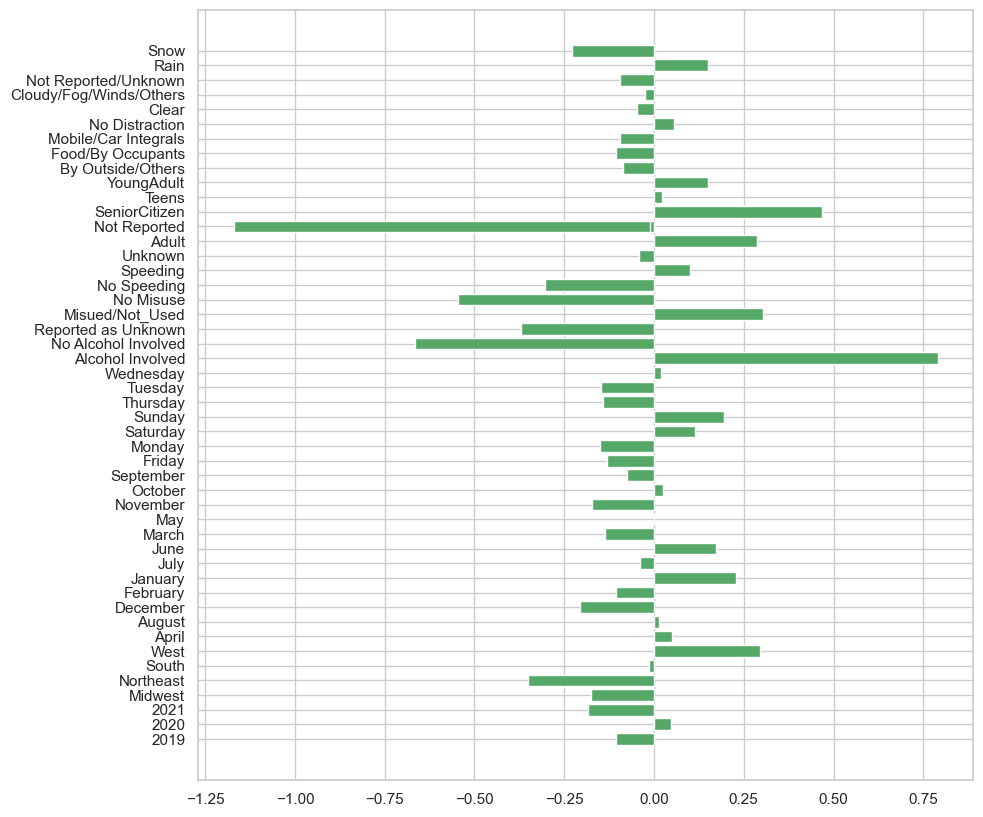

In [152]:
imp = model4.coef_.flatten()
plt.rcParams["figure.figsize"]=(10,10)
plt.barh(X_resampled_25.columns,imp,color="g")
plt.show()

In [153]:
# RandF= RandomForestClassifier()
# model4_RF= RandF.fit(X_train,y_train)
# pred_model4_RF = model4_RF.predict(X_test)
# print(metrics.classification_report(y_test,pred_model4_RF))

In [154]:
# cv= RepeatedKFold(n_splits=5, random_state=798, n_repeats=3)
# cross_val_score(model4_RF, X_train, y_train, cv=cv, scoring='accuracy').mean()

In [155]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
r_search = RandomizedSearchCV(RandF, 
                                 param_distributions = param_dist, 
                                 n_iter=3, 
                                 cv=5, random_state=49)

# Fit the random search object to the data
r_search.fit(X_train, y_train)
model4_RF = r_search.best_estimator_
print('Best hyperparameters:',  r_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 446}


In [156]:
pred_model4_RF = model4_RF.predict(X_test)
print(metrics.classification_report(y_test,pred_model4_RF))

              precision    recall  f1-score   support

           0       0.85      0.99      0.92    205298
           1       0.88      0.31      0.46     51232

    accuracy                           0.85    256530
   macro avg       0.87      0.65      0.69    256530
weighted avg       0.86      0.85      0.82    256530

